In [19]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
import json
from math import pi
import matplotlib.pyplot as plt

# --- 첫 번째 코드: 모델 및 자산 로드 ---
def load_ml_assets():
    assets = {}
    try:
        assets['model_dm'] = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
        assets['scaler_dm'] = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
        assets['features_dm'] = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
        assets['train_means_dm'] = joblib.load('train_means_dm_real.pkl')

        assets['model_hp'] = joblib.load('For_HE_HP_calibrated_real.pkl')
        assets['scaler_hp'] = joblib.load('HE_HP_scaler_real.pkl')
        assets['features_hp'] = joblib.load('HE_HP_input_features_list_real.pkl')
        assets['train_means_hp'] = joblib.load('train_means_hp_real.pkl')

        assets['model_obesity'] = joblib.load('For_HE_obe_calibrated_real.pkl')
        assets['scaler_obesity'] = joblib.load('HE_obe_scaler_real.pkl')
        assets['features_obesity'] = joblib.load('HE_obe_input_features_list_real.pkl')
        assets['train_means_obesity'] = joblib.load('train_means_obe_real.pkl')
        print("모든 모델 파일 로드 성공.")
    except FileNotFoundError as e:
        print(f"오류: 모델 파일을 찾을 수 없습니다. {e}")
        exit()
    except Exception as e:
        print(f"오류: 모델 파일 로드 중 예상치 못한 오류 발생: {e}")
        exit()
    
    try:
        assets['model_scores'] = joblib.load('model_accuracies.pkl')
        print("모델 정확도 로드 성공.")
    except FileNotFoundError:
        print("경고: 'model_accuracies.pkl' 파일을 찾을 수 없습니다. 모델 정확도가 0으로 처리됩니다.")
        assets['model_scores'] = {"당뇨병": 0.0, "고혈압": 0.0, "비만": 0.0}
    return assets

# --- 클래스 및 맵 정의 ---
DIABETES_EXPLANATIONS = {
    0: "혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.",
    1: "혈당이 정상보다 높지만 당뇨병 경계형으로 간주됩니다. 생활습관 개선이 필요합니다.",
    2: "당뇨병으로 예측되었습니다. 전문가와 상담이 필요합니다."
}

HYPERTENSION_EXPLANATIONS = {
    0: "혈압이 정상 범위에 있습니다.",
    1: "혈압이 정상보다 높지만 고혈압 전단계로 간주됩니다. 건강 관리가 필요합니다.",
    2: "고혈압 전단계로, 생활습관 개선과 치료가 필요할 수 있습니다.",
    3: "고혈압으로 예측되었습니다. 전문가의 진단과 치료가 필요합니다."
}

OBESITY_EXPLANATIONS = {
    0: "저체중입니다. 체중 증가가 필요할 수 있습니다.",
    1: "정상 체중입니다. 유지 관리가 필요합니다.",
    2: "과체중입니다. 체중 감량을 고려할 수 있습니다.",
    3: "비만입니다. 체중 감량과 건강 관리가 필요합니다.",
    4: "고도 비만입니다. 전문가의 진단과 관리가 필요합니다.",
    5: "초고도 비만입니다. 전문가의 도움을 받아야 합니다."
}

TOP_FEATURES_MAP = {
    "당뇨병": {"primary": "HE_glu"},
    "고혈압": {"primary": "HE_sbp1", "secondary": "HE_dbp1"},
    "비만": {"primary": "HE_BMI"}
}

FEATURE_LABEL_MAP = {
    "HE_sbp1": "수축기 혈압",
    "HE_dbp1": "이완기 혈압",
    "HE_glu": "공복혈당",
    "HE_BMI": "BMI",
    "HE_HbA1c": "당화혈색소"
}

# --- 사용자 입력 매핑 ---
def map_user_raw_input(raw_user_data):
    mapped_data = raw_user_data.copy()
    be3_31_raw = mapped_data.get('BE3_31')
    if be3_31_raw in [1, 88]: mapped_data['BE3_31'] = 0
    elif be3_31_raw == 2: mapped_data['BE3_31'] = 1
    elif be3_31_raw == 3: mapped_data['BE3_31'] = 2
    elif be3_31_raw == 4: mapped_data['BE3_31'] = 3
    elif be3_31_raw == 5: mapped_data['BE3_31'] = 4
    elif be3_31_raw == 6: mapped_data['BE3_31'] = 5
    elif be3_31_raw == 7: mapped_data['BE3_31'] = 6
    elif be3_31_raw == 8: mapped_data['BE3_31'] = 7
    else: mapped_data['BE3_31'] = np.nan

    be3_33_raw = mapped_data.get('BE3_33')
    if be3_33_raw in [88, 99]: mapped_data['BE3_33'] = 0

    l_br_fq_raw = mapped_data.get('L_BR_FQ')
    if l_br_fq_raw in [None, 9]: mapped_data['L_BR_FQ'] = np.nan
    elif l_br_fq_raw == 1: mapped_data['L_BR_FQ'] = 6.0
    elif l_br_fq_raw == 2: mapped_data['L_BR_FQ'] = 3.5
    elif l_br_fq_raw == 3: mapped_data['L_BR_FQ'] = 1.5
    elif l_br_fq_raw == 4: mapped_data['L_BR_FQ'] = 0.0

    bd1_11_raw = mapped_data.get('BD1_11')
    if bd1_11_raw in [None, 9]: mapped_data['BD1_11'] = np.nan
    elif bd1_11_raw in [1, 8]: mapped_data['BD1_11'] = 0
    elif bd1_11_raw == 2: mapped_data['BD1_11'] = 6
    elif bd1_11_raw == 3: mapped_data['BD1_11'] = 12
    elif bd1_11_raw == 4: mapped_data['BD1_11'] = 42
    elif bd1_11_raw == 5: mapped_data['BD1_11'] = 130
    elif bd1_11_raw == 6: mapped_data['BD1_11'] = 286

    bd2_1_raw = mapped_data.get('BD2_1')
    if bd2_1_raw in [None, 8, 9]: mapped_data['BD2_1'] = np.nan
    elif bd2_1_raw == 1: mapped_data['BD2_1'] = 1.5
    elif bd2_1_raw == 2: mapped_data['BD2_1'] = 3.5
    elif bd2_1_raw == 3: mapped_data['BD2_1'] = 5.5
    elif bd2_1_raw == 4: mapped_data['BD2_1'] = 8.0
    elif bd2_1_raw == 5: mapped_data['BD2_1'] = 10.0

    bs3_2_raw = mapped_data.get('BS3_2')
    if bs3_2_raw == 888: mapped_data['BS3_2'] = 0
    elif bs3_2_raw == 999: mapped_data['BS3_2'] = np.nan

    return mapped_data

# --- 입력 유효성 검사 및 클리핑 ---
def validate_and_clip_input(user_data, disease_name):
    validated_data = user_data.copy()
    warning_messages = []

    if disease_name == "당뇨병":
        glu = validated_data.get('HE_glu')
        hba1c = validated_data.get('HE_HbA1c')
        if glu is not None and (glu < 10 or glu > 600):
            warning_messages.append(f"공복혈당({glu})은(는) 비정상적인 범위입니다.")
            validated_data['HE_glu'] = np.clip(glu, 10, 600)
        if hba1c is not None and (hba1c < 3 or hba1c > 20):
            warning_messages.append(f"당화혈색소({hba1c})은(는) 비정상적인 범위입니다.")
            validated_data['HE_HbA1c'] = np.clip(hba1c, 3, 20)

    elif disease_name == "고혈압":
        sbp = validated_data.get('HE_sbp1')
        dbp = validated_data.get('HE_dbp1')
        if sbp is not None and (sbp < 40 or sbp > 300):
            warning_messages.append(f"수축기 혈압({sbp}mmHg)은(는) 비정상적인 값입니다.")
            validated_data['HE_sbp1'] = np.clip(sbp, 40, 300)
        if dbp is not None and (dbp < 20 or dbp > 180):
            warning_messages.append(f"이완기 혈압({dbp}mmHg)은(는) 비정상적인 값입니다.")
            validated_data['HE_dbp1'] = np.clip(dbp, 20, 180)

    elif disease_name == "비만":
        bmi = validated_data.get('HE_BMI')
        ht = validated_data.get('HE_ht')
        wt = validated_data.get('HE_wt')
        if bmi is not None and (bmi < 10 or bmi > 60):
            warning_messages.append(f"BMI({bmi})은(는) 비정상적인 범위입니다.")
            validated_data['HE_BMI'] = np.clip(bmi, 10, 60)
        if ht is not None and wt is not None and ht > 0:
            calculated_bmi = round(wt / ((ht/100)**2), 1)
            input_bmi_val = validated_data.get('HE_BMI')
            if input_bmi_val is None or abs(calculated_bmi - input_bmi_val) > 2:
                validated_data['HE_BMI'] = calculated_bmi

    return validated_data, warning_messages

# --- HbA1c 추정 ---
def estimate_hba1c_from_glucose(glu):
    return round((glu + 46.7) / 28.7, 1)

# --- 모델 입력 준비 ---
def prepare_for_prediction(user_data, features, scaler, train_means):
    user_df = pd.DataFrame([user_data]).reindex(columns=features)
    user_df = user_df.fillna(train_means)
    user_scaled = scaler.transform(user_df)
    return user_scaled

# --- 질병 확률 예측 ---
def predict_disease_probabilities(user_scaled, model, stages):
    probs = model.predict_proba(user_scaled)[0]
    stage_index = np.argmax(probs)
    predicted_class_name = stages.get(stage_index, "Unknown")
    class_probs_formatted = [f"{probs[i]:.2f}" for i in range(len(probs))]
    normal_class_index = 0
    if "비만" in stages.values() and predicted_class_name == "정상 체중":
        normal_class_index = list(stages.keys())[list(stages.values()).index("정상 체중")]
    prob_normal_class = float(probs[normal_class_index]) if normal_class_index < len(probs) else 0.0
    return {
        "probabilities": class_probs_formatted,
        "predicted_class_index": stage_index,
        "class_name": predicted_class_name,
        "prob_normal_class": prob_normal_class
    }

# --- 질병 보고서 생성 ---
def generate_disease_report(user_name, disease_name, prediction_result, user_validated_data, model_scores_dict):
    normal_class_index_map = {"당뇨병": 0, "고혈압": 0, "비만": 1}
    class_labels_map = {
        "당뇨병": ["정상", "경계형 당뇨", "당뇨병"],
        "고혈압": ["정상 혈압", "주의 혈압 단계", "고혈압 전단계", "고혈압"],
        "비만": ["저체중", "정상 체중", "과체중", "비만", "고도 비만", "초고도 비만"]
    }
    predicted_class_name = prediction_result['class_name']
    prob_normal_class = prediction_result['prob_normal_class']
    health_score = round(prob_normal_class * 100, 1)
    predicted_prob_raw = float(prediction_result['probabilities'][prediction_result['predicted_class_index']])
    predicted_prob_str = f"{predicted_prob_raw * 100:.0f}%"
    primary_feature_info = {}

    if disease_name == "고혈압":
        sbp_val = user_validated_data.get(TOP_FEATURES_MAP["고혈압"]["primary"])
        dbp_val = user_validated_data.get(TOP_FEATURES_MAP["고혈압"]["secondary"])
        sbp_status = "정상" if sbp_val < 120 else "주의혈압" if sbp_val <= 129 else "위험 (고혈압1기)" if sbp_val <= 139 else "고위험 (고혈압2기)"
        dbp_status = "정상" if dbp_val < 80 else "위험 (고혈압1기)" if dbp_val <= 89 else "고위험 (고혈압2기)"
        primary_feature_info["수축기 혈압"] = {"값": sbp_val, "상태": sbp_status, "정상_기준": "<120mmHg"}
        primary_feature_info["이완기 혈압"] = {"값": dbp_val, "상태": dbp_status, "정상_기준": "<80mmHg"}

    elif disease_name == "당뇨병":
        glu_val = user_validated_data.get(TOP_FEATURES_MAP["당뇨병"]["primary"])
        glu_status = "정상" if glu_val <= 99 else "주의" if glu_val <= 125 else "고위험"
        primary_feature_info[FEATURE_LABEL_MAP['HE_glu']] = {"값": glu_val, "상태": glu_status, "정상_기준": "70~99"}

    elif disease_name == "비만":
        bmi_val = user_validated_data.get(TOP_FEATURES_MAP["비만"]["primary"])
        bmi_status = "저체중" if bmi_val < 18.5 else "정상 체중" if bmi_val <= 22.9 else "과체중" if bmi_val <= 24.9 else "비만 1단계" if bmi_val <= 29.9 else "비만 2단계" if bmi_val <= 34.9 else "초고도 비만"
        primary_feature_info[FEATURE_LABEL_MAP['HE_BMI']] = {"값": bmi_val, "상태": bmi_status, "정상_기준": "18.5~22.9"}

    model_accuracy_str = f"{model_scores_dict.get(disease_name, 0.0):.1f}%"
    return {
        "질병": disease_name,
        "예측_상태": predicted_class_name,
        "예측_확률": predicted_prob_str,
        "정상_확률": f"{prob_normal_class * 100:.1f}%",
        "모델_정확도": model_accuracy_str,
        "주요_지표": primary_feature_info,
        "건강_점수": health_score
    }

# --- 생활습관 점수화 ---
def calculate_smoking_score(bs3_2):
    if bs3_2 is None or pd.isna(bs3_2) or bs3_2 == 999:
        return 12.5
    if bs3_2 == 0:
        return 38.0
    elif bs3_2 <= 10:
        ftnd_score_level = 0
    elif bs3_2 <= 20:
        ftnd_score_level = 1
    elif bs3_2 <= 30:
        ftnd_score_level = 2
    else:
        ftnd_score_level = 3
    return round(38.0 * (3 - ftnd_score_level) / 3, 1)

def calculate_walking_score(be3_33, be3_31):
    if be3_31 is None or be3_33 is None or pd.isna(be3_31) or pd.isna(be3_33):
        return 14.0
    if be3_31 == 0 or be3_33 == 0:
        return 0.0
    met = (be3_33) * 3.3 * be3_31
    if met >= 3000:
        base_score_level = 3
    elif met >= 600:
        base_score_level = 2
    else:
        base_score_level = 1
    return round(28.0 * (base_score_level - 1) / 2, 1)

def calculate_alcohol_score(bd1_11, bd2_1):
    if bd1_11 is None or bd2_1 is None or pd.isna(bd1_11) or pd.isna(bd2_1):
        return 10.0
    if bd1_11 == 0:
        freq_score = 0
    elif bd1_11 <= 12:
        freq_score = 0
    elif bd1_11 <= 42:
        freq_score = 1
    else:
        freq_score = 2
    if bd2_1 <= 1.5:
        amount_score = 0
    elif bd2_1 <= 3.5:
        amount_score = 1
    else:
        amount_score = 2
    total_risk_level = freq_score + amount_score
    return round(20.0 * (4 - total_risk_level) / 4, 1)

def calculate_breakfast_score(l_br_fq):
    if l_br_fq is None or pd.isna(l_br_fq):
        return 7.5
    if l_br_fq >= 5:
        level = 2
    elif l_br_fq >= 1:
        level = 1
    else:
        level = 0
    return round(15.0 * level / 2, 1)

# --- 두 번째 코드: 데이터 로드 및 전처리 ---
df = pd.read_csv("건강데이터_2022_2023_합본.csv")
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
    '1.0': 6, '2.0': 3.5, '3.0': 1.5, '4.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')
df['BS3_2'] = df['BS3_2'].replace(888, 0)
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan})
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)
df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({'999.0': np.nan})
df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 6, '3.0': 12, '4.0': 42, '5.0': 130, '6.0': 286,
    '8.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

def determine_he_hp2(sbp, dbp):
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan
    if sbp >= 140 or dbp >= 90:
        return 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        return 3
    elif 120 <= sbp <= 129 and dbp < 80:
        return 2
    else:
        return 1

def determine_he_dm_hba1c2(glu):
    if pd.isna(glu):
        return np.nan
    if glu <= 99:
        return 1
    elif 100 <= glu <= 125:
        return 2
    else:
        return 3

def determine_he_obe2(bmi):
    if pd.isna(bmi):
        return np.nan
    if bmi <= 18.5:
        return 1
    elif 18.5 < bmi <= 22.9:
        return 2
    elif 22.9 < bmi <= 24.9:
        return 3
    elif 24.9 < bmi <= 29.9:
        return 4
    elif 29.9 < bmi <= 34.9:
        return 5
    else:
        return 6

df['HE_HP2'] = df.apply(lambda row: determine_he_hp2(row['HE_sbp1'], row['HE_dbp1']), axis=1)
df['HE_DM_HbA1c2'] = df.apply(lambda row: determine_he_dm_hba1c2(row['HE_glu']), axis=1)
df['HE_obe2'] = df.apply(lambda row: determine_he_obe2(row['HE_BMI']), axis=1)
df_clustering = df.dropna(subset=['HE_HP2', 'HE_DM_HbA1c2', 'HE_obe2'])
selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'L_BR_FQ']
for col in selected_cols:
    if df_clustering[col].isnull().any():
        mode_value = df_clustering[col].mode(dropna=True)
        if not mode_value.empty:
            df_clustering.loc[:, col] = df_clustering[col].fillna(mode_value[0])
        else:
            df_clustering.loc[:, col] = df_clustering[col].fillna(0)

# 데이터 로드 (실제 파일 경로에 맞게 수정해주세요)
df = pd.read_csv("건강데이터_2022_2023_합본.csv")
df = df[(df['HE_glu'] >= 50) & (df['HE_glu'] <= 400)]

# 전처리: BE3_31 (1주일 간 걷기 일수)
df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3, '5.0': 4, '6.0': 5,
    '7.0': 6, '8.0': 7, '88.0': 0, '99.0': np.nan, 'nan': np.nan
})
df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')

# 전처리: L_BR_FQ (최근 1년 동안 1주 동안 아침식사 빈도)
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
    '1.0': 6, '2.0': 3.5, '3.0': 1.5, '4.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')

# 전처리: tobacco (일반 담배 + 전자 담배 하루 평균 흡연량)
df['BS3_2'] = df['BS3_2'].replace(888, 0)
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan})
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)
df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({'999.0': np.nan})
df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

# 전처리: BD1_11 (1년간 음주 빈도) - 연간 횟수로 변환
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 6, '3.0': 12, '4.0': 42, '5.0': 130, '6.0': 286,
    '8.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

# 고혈압 파생변수 생성 (HE_HP2)
def determine_he_hp2(sbp, dbp):
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan
    if sbp >= 140 or dbp >= 90:
        return 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        return 3
    elif 120 <= sbp <= 129 and dbp < 80:
        return 2
    else:
        return 1

# 당뇨 파생변수 생성 (HE_DM_HbA1c2)
def determine_he_dm_hba1c2(glu):
    if pd.isna(glu):
        return np.nan
    if glu <= 99:
        return 1
    elif 100 <= glu <= 125:
        return 2
    else:
        return 3

# 비만 파생변수 생성 (HE_obe2)
def determine_he_obe2(bmi):
    if pd.isna(bmi):
        return np.nan
    if bmi <= 18.5:
        return 1
    elif 18.5 < bmi <= 22.9:
        return 2
    elif 22.9 < bmi <= 24.9:
        return 3
    elif 24.9 < bmi <= 29.9:
        return 4
    elif 29.9 < bmi <= 34.9:
        return 5
    else:
        return 6

df['HE_HP2'] = df.apply(lambda row: determine_he_hp2(row['HE_sbp1'], row['HE_dbp1']), axis=1)
df['HE_DM_HbA1c2'] = df.apply(lambda row: determine_he_dm_hba1c2(row['HE_glu']), axis=1)
df['HE_obe2'] = df.apply(lambda row: determine_he_obe2(row['HE_BMI']), axis=1)
df['HE_HP2'] = pd.to_numeric(df['HE_HP2'], errors='coerce')
df['HE_DM_HbA1c2'] = pd.to_numeric(df['HE_DM_HbA1c2'], errors='coerce')
df['HE_obe2'] = pd.to_numeric(df['HE_obe2'], errors='coerce')

# 결측치 제거 및 군집 분석에 사용할 컬럼 선택
df_clustering = df.dropna(subset=['HE_HP2', 'HE_DM_HbA1c2', 'HE_obe2'])
selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'L_BR_FQ']

# 선택된 컬럼의 결측치를 최빈값으로 대체
for col in selected_cols:
    if df_clustering[col].isnull().any():
        mode_value = df_clustering[col].mode(dropna=True)
        if not mode_value.empty:
            df_clustering.loc[:, col] = df_clustering[col].fillna(mode_value[0])
        else:
            df_clustering.loc[:, col] = df_clustering[col].fillna(0)


# 사전 계산된 군집 평균 데이터
precalculated_means = {
    'HE_HP2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [0.212965, 0.346154, 0.263829, 0.283081, 3.773973, 0.532374, 3.081522],
            '하루 평균 흡연량': [0.180919, 0.803408, 0.243425, 0.696676, 18.815068, 18.654676, 1.434783],
            '1주일 간 걷기 일수': [1.006360, 5.964613, 6.167879, 1.013850, 3.102740, 3.805755, 4.766304],
            '1주일 간 아침식사 빈도': [5.547703, 0.613368, 5.585898, 0.623269, 2.616438, 3.769784, 3.337862]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [3.257282, 0.600634, 0.173377, 0.227414, 0.761134, 5.500000, 1.003752],
            '하루 평균 흡연량': [0.582524, 0.444444, 0.102253, 0.382550, 23.385965, 6.716981, 13.719512],
            '1주일 간 걷기 일수': [5.291262, 3.584229, 6.287695, 1.201342, 1.666667, 2.660377, 6.024390],
            '1주일 간 아침식사 빈도': [5.432039, 0.605735, 5.757366, 5.692394, 3.789474, 3.924528, 3.152439]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.517830, 0.747283, 2.083208, 0.473159, 5.500000, 1.960664],
            '하루 평균 흡연량': [0.255906, 1.091078, 19.352941, 0.420361, 2.595745, 17.242424],
            '1주일 간 걷기 일수': [6.213583, 3.780669, 1.895425, 1.308703, 4.085106, 5.469697],
            '1주일 간 아침식사 빈도': [5.778543, 0.697026, 2.271242, 5.749589, 4.049645, 5.295455]
        }, index=[0, 1, 2, 3, 4, 5]),
        4: pd.DataFrame({
            '1주일 간 음주 빈도': [5.500000, 0.463656, 0.471816, 2.740812, 0.930769],
            '하루 평균 흡연량': [2.284672, 0.332907, 0.317814, 20.272222, 1.310000],
            '1주일 간 걷기 일수': [3.729927, 6.289373, 1.212551, 3.850000, 3.813333],
            '1주일 간 아침식사 빈도': [4.463504, 5.839949, 5.731781, 3.738889, 0.693333]
        }, index=[0, 1, 2, 3, 4]),
    },
    'HE_DM_HbA1c2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [0.679037, 3.699045, 0.205307, 0.495192, 1.637577, 0.247029],
            '하루 평균 흡연량': [0.883784, 1.920382, 0.305901, 0.764344, 19.815618, 0.317173],
            '1주일 간 걷기 일수': [6.015315, 4.474522, 1.086957, 1.079918, 3.561822, 6.187346],
            '1주일 간 아침식사 빈도': [0.591892, 4.639331, 5.596273, 0.627049, 3.206074, 5.622021]
        }, index=[0, 1, 2, 3, 4, 5]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [0.467910, 0.868637, 1.435988, 5.500000, 0.474998],
            '하루 평균 흡연량': [0.438253, 1.461412, 19.321555, 5.978166, 0.407047],
            '1주일 간 걷기 일수': [6.262048, 3.768473, 3.653710, 3.890830, 1.222357],
            '1주일 간 아침식사 빈도': [5.800452, 0.623974, 3.793286, 4.109170, 5.717497]
        }, index=[0, 1, 2, 3, 4]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.365672, 0.374903, 1.797498, 0.454709, 2.443396, 4.320225],
            '하루 평균 흡연량': [0.492537, 0.199495, 21.493976, 0.953271, 19.056604, 1.000000],
            '1주일 간 걷기 일수': [1.223881, 6.353535, 3.795181, 3.943925, 3.622642, 3.662921],
            '1주일 간 아침식사 빈도': [5.763682, 5.886364, 5.879518, 0.668224, 1.179245, 5.382022]
        }, index=[0, 1, 2, 3, 4, 5]),
    },
    'HE_obe2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [3.462264, 0.056121, 0.347728, 0.147807, 1.490074, 0.463646],
            '하루 평균 흡연량': [3.226415, 0.073930, 0.485380, 0.297521, 19.774194, 0.698630],
            '1주일 간 걷기 일수': [3.094340, 0.443580, 6.187135, 0.719008, 3.967742, 5.945205],
            '1주일 간 아침식사 빈도': [2.943396, 5.659533, 5.576023, 0.619835, 3.064516, 0.534247]
        }, index=[0, 1, 2, 3, 4, 5]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [1.346814, 0.619275, 0.418860, 5.237327, 0.692170, 0.278670],
            '하루 평균 흡연량': [18.386266, 0.748092, 0.245912, 7.737327, 0.670251, 0.306064],
            '1주일 간 걷기 일수': [3.497854, 1.219466, 6.217444, 3.718894, 6.069892, 1.216554],
            '1주일 간 아침식사 빈도': [3.343348, 0.885496, 5.662326, 4.158986, 0.585125, 5.677575]
        }, index=[0, 1, 2, 3, 4, 5]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.428221, 0.465444, 1.405400, 0.733680, 5.500000],
            '하루 평균 흡연량': [0.353503, 0.406190, 19.929293, 0.981982, 5.000000],
            '1주일 간 걷기 일수': [1.168790, 6.233075, 3.691919, 3.645045, 4.143836],
            '1주일 간 아침식사 빈도': [5.685510, 5.787234, 3.845960, 0.740541, 4.191781]
        }, index=[0, 1, 2, 3, 4]),
        4: pd.DataFrame({
            '1주일 간 음주 빈도': [1.745897, 0.476494, 0.474684, 4.074257, 0.400403],
            '하루 평균 흡연량': [20.120000, 0.413905, 0.444304, 2.267327, 0.994178],
            '1주일 간 걷기 일수': [3.673333, 6.226354, 1.289873, 4.603960, 3.608443],
            '1주일 간 아침식사 빈도': [3.465000, 5.767583, 5.724684, 2.785479, 0.788937]
        }, index=[0, 1, 2, 3, 4]),
        5: pd.DataFrame({
            '1주일 간 음주 빈도': [0.313474, 0.188658, 1.018219, 4.313953, 0.697115, 2.906780, 0.266827],
            '하루 평균 흡연량': [0.215686, 0.218978, 17.921053, 3.069767, 23.687500, 2.000000, 1.331250],
            '1주일 간 걷기 일수': [6.202614, 1.160584, 3.368421, 2.488372, 3.781250, 4.915254, 3.893750],
            '1주일 간 아침식사 빈도': [5.722222, 5.635036, 5.605263, 5.174419, 0.984375, 0.838983, 0.659375]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        6: pd.DataFrame({
            '1주일 간 음주 빈도': [0.202830, 5.500000, 0.407692, 0.332308, 1.230769],
            '하루 평균 흡연량': [0.198113, 7.692308, 0.642857, 0.400000, 20.360000],
            '1주일 간 걷기 일수': [0.424528, 5.230769, 3.942857, 6.480000, 3.840000],
            '1주일 간 아침식사 빈도': [5.787736, 4.730769, 0.600000, 5.625000, 3.480000]
        }, index=[0, 1, 2, 3, 4])
    }
}

# --- 통합 분석 함수 ---
def integrated_health_service(user_data_list):
    assets = load_ml_assets()
    results = {}
    
    for user_data in user_data_list:
        user_name = user_data['user_name']
        print(f"\n--- {user_name}님의 건강 및 생활습관 분석 시작 ---\n")
        checklist = HealthChecklist()
        
        # 첫 단계: 건강 점수 및 생활습 점수 계산
        raw_data = map_user_raw_input(user_data)
        disease_reports = []
        health_scores = []
        lifestyle_scores = {}
        
        # 당뇨병
        validated_data, warnings = validate_and_clip_input(raw_data, "당뇨병")
        if not validated_data.get('HE_HbA1c'):
            validated_data['HE_HbA1c'] = estimate_hba1c_from_glucose(validated_data.get('HE_glu', 90))
        user_scaled = prepare_for_prediction(validated_data, assets['features_dm'], assets['scaler_dm'], assets['train_means_dm'])
        dm_pred = predict_disease_probabilities(user_scaled, assets['model_dm'], {0: "정상", 1: "경계형 당뇨", 2: "당뇨병"})
        dm_pred['warnings'] = warnings
        dm_report = generate_disease_report(user_name, "당뇨병", dm_pred, validated_data, assets['model_scores'])
        disease_reports.append(dm_report)
        health_scores.append(dm_report['건강_점수'])
        
        # 고혈압
        validated_data, warnings = validate_and_clip_input(raw_data, "고혈압")
        user_scaled = prepare_for_prediction(validated_data, assets['features_hp'], assets['scaler_hp'], assets['train_means_hp'])
        hp_pred = predict_disease_probabilities(user_scaled, assets['model_hp'], {0: "정상 혈압", 1: "주의 혈압 단계", 2: "고혈압 전단계", 3: "고혈압"})
        hp_pred['warnings'] = warnings
        hp_report = generate_disease_report(user_name, "고혈압", hp_pred, validated_data, assets['model_scores'])
        disease_reports.append(hp_report)
        health_scores.append(hp_report['건강_점수'])
        
        # 비만
        validated_data, warnings = validate_and_clip_input(raw_data, "비만")
        user_scaled = prepare_for_prediction(validated_data, assets['features_obesity'], assets['scaler_obesity'], assets['train_means_obesity'])
        ob_pred = predict_disease_probabilities(user_scaled, assets['model_obesity'], {0: "저체중", 1: "정상 체중", 2: "과체중", 3: "비만", 4: "고도 비만", 5: "초고도 비만"})
        ob_pred['warnings'] = warnings
        ob_report = generate_disease_report(user_name, "비만", ob_pred, validated_data, assets['model_scores'])
        disease_reports.append(ob_report)
        health_scores.append(ob_report['건강_점수'])
        
        # 생활습 점수
        lifestyle_scores['흡연_점수'] = calculate_smoking_score(raw_data.get('BS3_2'))
        lifestyle_scores['걷기_점수'] = calculate_walking_score(raw_data.get('BE3_33'), raw_data.get('BE3_31'))
        lifestyle_scores['alcohol_점수'] = calculate_alcohol_score(raw_data.get('BD1_11'), raw_data.get('BD2_1'))
        lifestyle_scores['breakfast_점수'] = calculate_breakfast_score(raw_data.get('L_BR_FQ'))
        lifestyle_avg_score = round(sum(lifestyle_scores.values()) / len(lifestyle_scores.values()), 1)
        
        # 건강 평균 점수
        health_avg_score = round(sum(health_scores) / len(health_scores), 1)
        
        # 두 번째 단계: 실천율 점수 계산
        def analyze_condition(condition_type, condition_value, condition_labels, user_lifestyle_data):
            condition_value_int = int(condition_value)
            if condition_type not in precalculated_means or condition_value_int not in precalculated_means[condition_type]:
                print(f"\n{condition_type} 분류 {condition_labels[condition_value_int]}에 대한 사전 계산된 데이터가 없습니다.")
                return None
            df_condition = df_clustering[df_clustering[condition_type] == condition_value_int][selected_cols].copy()
            if df_condition.empty:
                print(f"{condition_type} 분류 데이터 부족.")
                return None
            scaler = StandardScaler()
            scaler.fit(df_condition[selected_cols])
            cluster, cluster_means = determine_cluster_with_precalculated_means(
                user_lifestyle_data, condition_value_int, scaler, precalculated_means, selected_cols, condition_type
            )
            if cluster is None:
                print(f"{condition_type} 군집을 찾을 수 없음.")
                return None
            target_cluster_index, target_cluster_means = find_healthier_and_similar_cluster(
                user_lifestyle_data, cluster_means, condition_value_int, precalculated_means, condition_type
            )
            if target_cluster_index is not None and target_cluster_index != 'self':
                compare_values = target_cluster_means.tolist()
            else:
                compare_values = cluster_means.tolist()
            categories = ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']
            plot_radar_chart(user_lifestyle_data, compare_values, categories, f"{user_name}님의 생활습관 vs 비교 군집 평균 ({condition_labels[condition_value_int]})")
            condition_name = {'HE_HP2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
            diff_alcohol = round(user_lifestyle_data[0] - compare_values[0], 2)
            if diff_alcohol > 0:
                checklist.add_feedback(condition_name, "1주일 간 음주 빈도", "줄여야", abs(diff_alcohol))
            elif diff_alcohol < 0:
                checklist.add_feedback(condition_name, "1주일 간 음주 빈도", "낮습니다", abs(diff_alcohol))
            else:
                checklist.add_feedback(condition_name, "1주일 간 음주 빈도", "적정", "적정")
            diff_smoking = round(user_lifestyle_data[1] - compare_values[1], 2)
            if diff_smoking > 0:
                checklist.add_feedback(condition_name, "하루 평균 흡연량", "줄여야", abs(diff_smoking))
            elif diff_smoking < 0:
                checklist.add_feedback(condition_name, "하루 평균 흡연량", "낮습니다", abs(diff_smoking))
            else:
                checklist.add_feedback(condition_name, "하루 평균 흡연량", "적정", "적정")
            diff_exercise = round(compare_values[2] - user_lifestyle_data[2], 2)
            if diff_exercise > 0:
                checklist.add_feedback(condition_name, "1주일 간 걷기 일수", "늘려야", abs(diff_exercise))
            elif diff_exercise < 0:
                checklist.add_feedback(condition_name, "1주일 간 걷기 일수", "충분", abs(diff_exercise))
            else:
                checklist.add_feedback(condition_name, "1주일 간 걷기 일수", "적정", "적정")
            diff_breakfast = round(compare_values[3] - user_lifestyle_data[3], 2)
            if diff_breakfast > 0:
                checklist.add_feedback(condition_name, "1주일 간 아침식사 빈도", "늘려야", abs(diff_breakfast))
            elif diff_breakfast < 0:
                checklist.add_feedback(condition_name, "1주일 간 아침식사 빈도", "충분", abs(diff_breakfast))
            else:
                checklist.add_feedback(condition_name, "1주일 간 아침식사 빈도", "적정", "적정")

        # 고혈압 분석
        he_hp2 = determine_he_hp2(raw_data.get('HE_sbp1'), raw_data.get('HE_dbp1'))
        he_hp2_labels = {1: "정상", 2: "주의 혈압", 3: "고혈압 전단계", 4: "고혈압"}
        if not pd.isna(he_hp2):
            analyze_condition('HE_HP2', he_hp2, he_hp2_labels, [raw_data.get('BD1_11', 0), raw_data.get('BS3_2', 0), raw_data.get('BE3_31', 0), raw_data.get('L_BR_FQ', 0)])

        # 당뇨 분석
        he_dm_hba1c2 = determine_he_dm_hba1c2(raw_data.get('HE_glu'))
        he_dm_hba1c2_labels = {1: "정상", 2: "당뇨 전단계", 3: "당뇨"}
        if not pd.isna(he_dm_hba1c2):
            analyze_condition('HE_DM_HbA1c2', he_dm_hba1c2, he_dm_hba1c2_labels, [raw_data.get('BD1_11', 0), raw_data.get('BS3_2', 0), raw_data.get('BE3_31', 0), raw_data.get('L_BR_FQ', 0)])

        # 비만 분석
        he_obe2 = determine_he_obe2(raw_data.get('HE_BMI'))
        he_obe2_labels = {1: "저체중", 2: "정상", 3: "과체중", 4: "비만", 5: "고도비만", 6: "초고도비만"}
        if not pd.isna(he_obe2):
            analyze_condition('HE_obe2', he_obe2, he_obe2_labels, [raw_data.get('BD1_11', 0), raw_data.get('BS3_2', 0), raw_data.get('BE3_31', 0), raw_data.get('L_BR_FQ', 0)])

        # 체크리스트 상태 업데이트 (예: 일부 항목 실천 완료로 가정)
        checklist.check_item("고혈압", "1주일 간 음주 빈도")
        checklist.check_item("당뇨", "1주일 간 걷기 일수")
        checklist.check_item("비만", "하루 평균 흡연량")
        checklist.display_checklist()
        checklist.save_checklist(f"{user_name}_checklist.json")
        
        # 실천율 점수
        checklist_status = checklist.get_checklist_status()
        completion_rate = checklist_status['수행 비율']
        
        # 최종 점수 계산
        final_score = round(health_avg_score * 0.4 + lifestyle_avg_score * 0.3 + completion_rate * 0.3, 1)
        
        # 결과 저장
        results[user_name] = {
            "질병_세부_결과": disease_reports,
            "건강_평균_점수": health_avg_score,
            "생활습관_평균_점수": lifestyle_avg_score,
            "실천율_점수": completion_rate,
            "총점": final_score,
            "각_생활습관_점수": lifestyle_scores
        }
    
    # 승자 결정
    print("\n--- 최종 결과 ---\n")
    print("사용자별 최종 점수:")
    max_score = -1
    winner = None
    for user_name, result in results.items():
        print(f"- {user_name}: {result['총점']:.1f}점")
        if result['총점'] > max_score:
            max_score = result['총점']
            winner = user_name
    
    print(f"\n최종 승자는 **{winner}**님입니다! 축하드립니다!\n")
    
    # JSON 결과
    final_json = {k: v for k, v in results.items()}
    final_json['승자'] = winner
    print("\n--- 전체 결과 (JSON 형식) ---\n")
    print(json.dumps(final_json, ensure_ascii=False, indent=2))
    return final_json

# --- 사용자 데이터 입력 ---
user_data_list = [
    {
        "user_name": "홍길동",
        "HE_sbp1": 135,
        "HE_dbp1": 85,
        "HE_glu": 100,
        "HE_BMI": 21.8,
        "BS3_2": 10,
        "BE3_31": 2,
        "BE3_33": 30,
        "BD1_11": 2,
        "BD2_1": 1,
        "L_BR_FQ": 3,
        "HE_ht": 170,
        "HE_wt": 65
    },
    {
        "user_name": "김철수",
        "HE_sbp1": 118,
        "HE_dbp1": 76,
        "HE_glu": 92,
        "HE_BMI": 23.7,
        "BS3_2": 0,
        "BE3_31": 2,
        "BE3_33": 30,
        "BD1_11": 3,
        "BD2_1": 2,
        "L_BR_FQ": 2,
        "HE_ht": 175,
        "HE_wt": 70
    }
]

# --- 서비스 실행 ---
if __name__ == "__main__":
    integrated_health_service(user_data_list)

C:\Users\asia\AppData\Local\Temp\ipykernel_15548\92100492.py:305: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
C:\Users\asia\AppData\Local\Temp\ipykernel_15548\92100492.py:316: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({
C:\Users\asia\AppData\Local\Temp\ipykernel_15548\92100492.py:378: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the ol

모든 모델 파일 로드 성공.
모델 정확도 로드 성공.

--- 홍길동님의 건강 및 생활습관 분석 시작 ---

경고: 내부 컬럼 'BD1_11'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.
경고: 내부 컬럼 'BE3_31'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.
경고: 스케일링하려는 사전 계산된 평균 데이터에 결심치가 포함되어 있습니다.
HE_HP2 군집을 찾을 수 없음.
경고: 내부 컬럼 'BD1_11'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.
경고: 내부 컬럼 'BE3_31'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.
경고: 스케일링하려는 사전 계산된 평균 데이터에 결심치가 포함되어 있습니다.
HE_DM_HbA1c2 군집을 찾을 수 없음.
경고: 내부 컬럼 'BD1_11'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.
경고: 내부 컬럼 'BE3_31'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.
경고: 스케일링하려는 사전 계산된 평균 데이터에 결심치가 포함되어 있습니다.
HE_obe2 군집을 찾을 수 없음.
항목 고혈압_1주일 간 음주 빈도가 존재하지 않습니다.
항목 당뇨_1주일 간 걷기 일수가 존재하지 않습니다.
항목 비만_하루 평균 흡연량가 존재하지 않습니다.

=== 건강 체크리스트 ===


고혈압 점수: 0.00/100
당뇨 점수: 0.00/100
비만 점수: 0.00/100
총 실천율: 0.00%
체크리스트가 홍길동_checklist.json에 저장되었습니다.


--- 김철수님의 건강 및 생활습관 분석 시작 ---

경고: 내부 컬럼 'BD1_11'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.
경고: 내부 컬럼 'BE3_31'에 대한 텍스트 이름 매핑이 없거나 사전 계산된 데이터에 없습니다.
경고: 스케일링하려는 사전 계산된 평균 데이터에 결심치가 포함되어 있습니다.
HE_HP2 군집을 

C:\Users\asia\AppData\Local\Temp\ipykernel_15548\3659469600.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
C:\Users\asia\AppData\Local\Temp\ipykernel_15548\3659469600.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
C:\Users\asia\AppData\Local\Temp\ipykernel_15548\3659469600.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the

모든 모델 파일 로드 성공.
모델 정확도 로드 성공.

--- 홍길동님의 건강 및 생활습관 분석 시작 ---



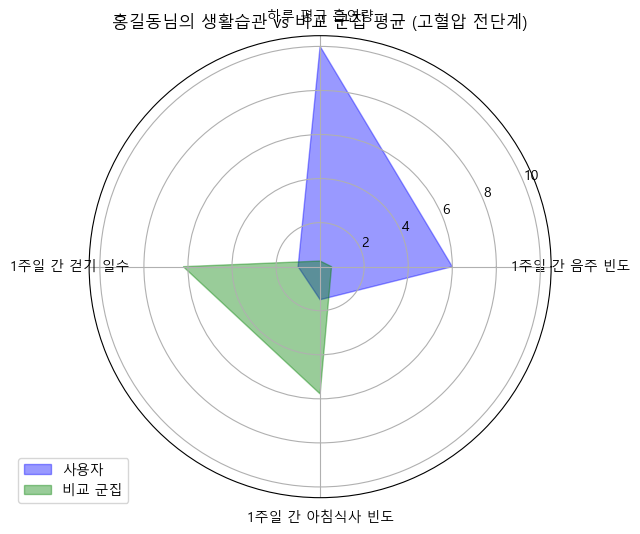

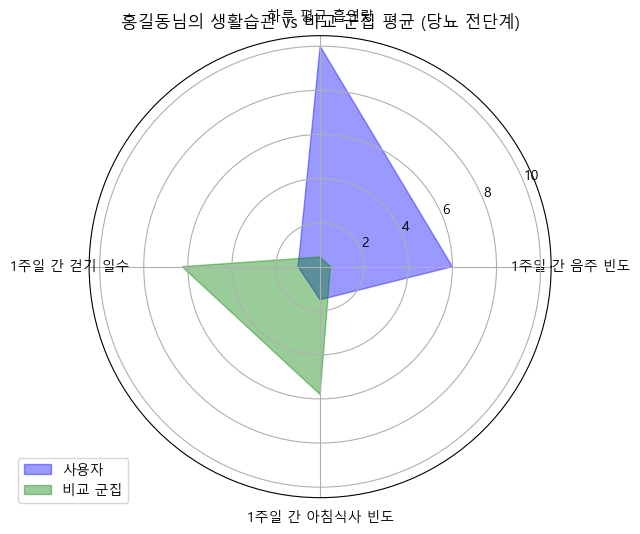

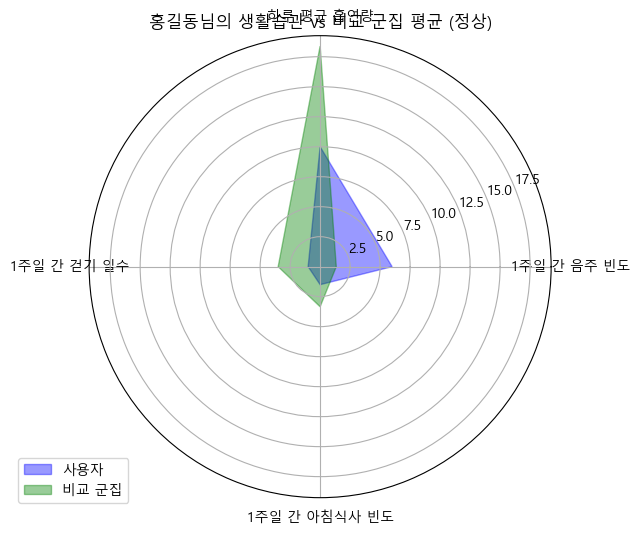


=== 건강 체크리스트 ===
| 질병   | 항목                   | 액션     |   목표값 | 체크여부   |   점수 |
|:-------|:-----------------------|:---------|---------:|:-----------|-------:|
| 고혈압 | 1주일 간 음주 빈도     | 줄여야   |     5.48 | ☑          |  19.80 |
| 고혈압 | 하루 평균 흡연량       | 줄여야   |     9.74 | ☐          |   0.00 |
| 고혈압 | 1주일 간 걷기 일수     | 늘려야   |     5.21 | ☐          |   0.00 |
| 고혈압 | 1주일 간 아침식사 빈도 | 늘려야   |     4.28 | ☐          |   0.00 |
| 당뇨   | 1주일 간 음주 빈도     | 줄여야   |     5.53 | ☐          |   0.00 |
| 당뇨   | 하루 평균 흡연량       | 줄여야   |     9.56 | ☐          |   0.00 |
| 당뇨   | 1주일 간 걷기 일수     | 늘려야   |     5.26 | ☑          |  27.72 |
| 당뇨   | 1주일 간 아침식사 빈도 | 늘려야   |     4.30 | ☐          |   0.00 |
| 비만   | 1주일 간 음주 빈도     | 줄여야   |     4.65 | ☐          |   0.00 |
| 비만   | 하루 평균 흡연량       | 낮습니다 |     8.38 | ☑          |  37.62 |
| 비만   | 1주일 간 걷기 일수     | 늘려야   |     2.50 | ☐          |   0.00 |
| 비만   | 1주일 간 아침식사 빈도 | 늘려야   |     1.84 | ☐          |   0.00 |

고혈압 점수: 19.80/100
당뇨 점수: 27.72/

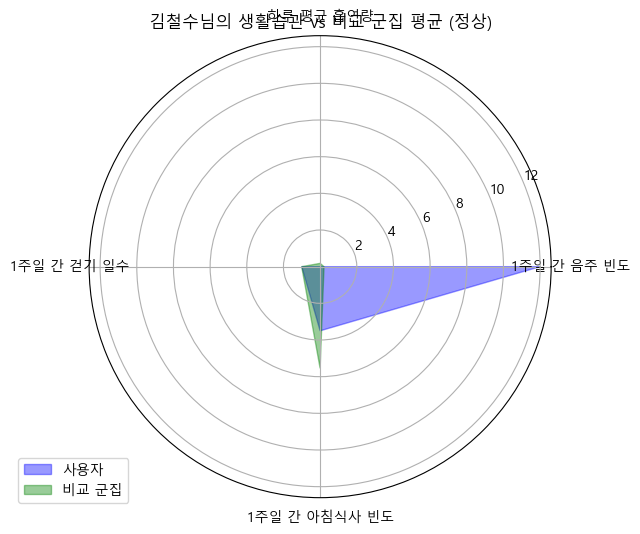

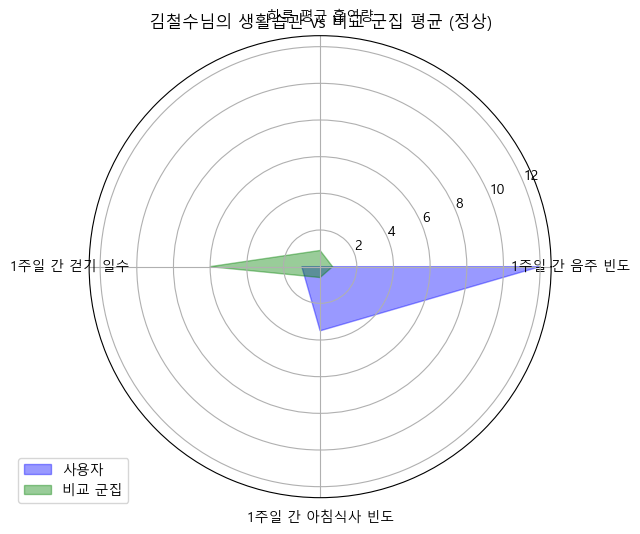

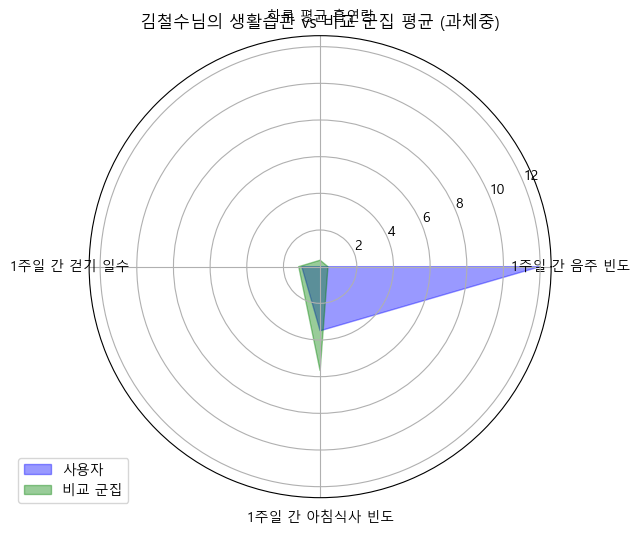


=== 건강 체크리스트 ===
| 질병   | 항목                   | 액션     |   목표값 | 체크여부   |   점수 |
|:-------|:-----------------------|:---------|---------:|:-----------|-------:|
| 고혈압 | 1주일 간 음주 빈도     | 줄여야   |    11.79 | ☑          |  19.80 |
| 고혈압 | 하루 평균 흡연량       | 낮습니다 |     0.18 | ☐          |   0.00 |
| 고혈압 | 1주일 간 걷기 일수     | 늘려야   |     0.01 | ☐          |   0.00 |
| 고혈압 | 1주일 간 아침식사 빈도 | 늘려야   |     2.05 | ☐          |   0.00 |
| 당뇨   | 1주일 간 음주 빈도     | 줄여야   |    11.32 | ☐          |   0.00 |
| 당뇨   | 하루 평균 흡연량       | 낮습니다 |     0.88 | ☐          |   0.00 |
| 당뇨   | 1주일 간 걷기 일수     | 늘려야   |     5.02 | ☑          |  27.72 |
| 당뇨   | 1주일 간 아침식사 빈도 | 충분     |     2.91 | ☐          |   0.00 |
| 비만   | 1주일 간 음주 빈도     | 줄여야   |    11.57 | ☐          |   0.00 |
| 비만   | 하루 평균 흡연량       | 낮습니다 |     0.35 | ☑          |  37.62 |
| 비만   | 1주일 간 걷기 일수     | 늘려야   |     0.17 | ☐          |   0.00 |
| 비만   | 1주일 간 아침식사 빈도 | 늘려야   |     2.19 | ☐          |   0.00 |

고혈압 점수: 19.80/100
당뇨 점수: 27.72/1

In [27]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import json
import matplotlib.pyplot as plt

# --- 컬럼 매핑 정의 ---
COLUMN_MAPPING = {
    'BD1_11': '1주일 간 음주 빈도',
    'tobacco': '하루 평균 흡연량',
    'BE3_31': '1주일 간 걷기 일수',
    'L_BR_FQ': '1주일 간 아침식사 빈도'
}

# --- 데이터 로드 및 전처리 ---
df = pd.read_csv("건강데이터_2022_2023_합본.csv")
df = df[(df['HE_glu'] >= 50) & (df['HE_glu'] <= 400)]

# 전처리: BE3_31 (1주일 간 걷기 일수)
df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3, '5.0': 4, '6.0': 5,
    '7.0': 6, '8.0': 7, '88.0': 0, '99.0': np.nan, 'nan': np.nan
})
df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')

# 전처리: L_BR_FQ (최근 1년 동안 1주 동안 아침식사 빈도)
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
    '1.0': 6, '2.0': 3.5, '3.0': 1.5, '4.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')

# 전처리: tobacco (일반 담배 + 전자 담배 하루 평균 흡연량)
df['BS3_2'] = df['BS3_2'].replace(888, 0)
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan})
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)
df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({'999.0': np.nan})
df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

# 전처리: BD1_11 (1년간 음주 빈도) - 연간 횟수로 변환
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 6, '3.0': 12, '4.0': 42, '5.0': 130, '6.0': 286,
    '8.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

# 파생변수 생성
def determine_he_hp2(sbp, dbp):
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan
    if sbp >= 140 or dbp >= 90:
        return 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        return 3
    elif 120 <= sbp <= 129 and dbp < 80:
        return 2
    else:
        return 1

def determine_he_dm_hba1c2(glu):
    if pd.isna(glu):
        return np.nan
    if glu <= 99:
        return 1
    elif 100 <= glu <= 125:
        return 2
    else:
        return 3

def determine_he_obe2(bmi):
    if pd.isna(bmi):
        return np.nan
    if bmi <= 18.5:
        return 1
    elif 18.5 < bmi <= 22.9:
        return 2
    elif 22.9 < bmi <= 24.9:
        return 3
    elif 24.9 < bmi <= 29.9:
        return 4
    elif 29.9 < bmi <= 34.9:
        return 5
    else:
        return 6

df['HE_HP2'] = df.apply(lambda row: determine_he_hp2(row['HE_sbp1'], row['HE_dbp1']), axis=1)
df['HE_DM_HbA1c2'] = df.apply(lambda row: determine_he_dm_hba1c2(row['HE_glu']), axis=1)
df['HE_obe2'] = df.apply(lambda row: determine_he_obe2(row['HE_BMI']), axis=1)
df['HE_HP2'] = pd.to_numeric(df['HE_HP2'], errors='coerce')
df['HE_DM_HbA1c2'] = pd.to_numeric(df['HE_DM_HbA1c2'], errors='coerce')
df['HE_obe2'] = pd.to_numeric(df['HE_obe2'], errors='coerce')

# 결측치 제거 및 군집 분석에 사용할 컬럼 선택
df_clustering = df.dropna(subset=['HE_HP2', 'HE_DM_HbA1c2', 'HE_obe2'])
selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'L_BR_FQ']

# 선택된 컬럼의 결측치를 최빈값으로 대체
for col in selected_cols:
    if df_clustering[col].isnull().any():
        mode_value = df_clustering[col].mode(dropna=True)
        if not mode_value.empty:
            df_clustering.loc[:, col] = df_clustering[col].fillna(mode_value[0])
        else:
            df_clustering.loc[:, col] = df_clustering[col].fillna(0)

# --- 모델 및 자산 로드 ---
def load_ml_assets():
    assets = {}
    try:
        assets['model_dm'] = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
        assets['scaler_dm'] = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
        assets['features_dm'] = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
        assets['train_means_dm'] = joblib.load('train_means_dm_real.pkl')

        assets['model_hp'] = joblib.load('For_HE_HP_calibrated_real.pkl')
        assets['scaler_hp'] = joblib.load('HE_HP_scaler_real.pkl')
        assets['features_hp'] = joblib.load('HE_HP_input_features_list_real.pkl')
        assets['train_means_hp'] = joblib.load('train_means_hp_real.pkl')

        assets['model_obesity'] = joblib.load('For_HE_obe_calibrated_real.pkl')
        assets['scaler_obesity'] = joblib.load('HE_obe_scaler_real.pkl')
        assets['features_obesity'] = joblib.load('HE_obe_input_features_list_real.pkl')
        assets['train_means_obesity'] = joblib.load('train_means_obe_real.pkl')
        print("모든 모델 파일 로드 성공.")
    except FileNotFoundError as e:
        print(f"오류: 모델 파일을 찾을 수 없습니다. {e}")
        exit()
    except Exception as e:
        print(f"오류: 모델 파일 로드 중 예상치 못한 오류 발생: {e}")
        exit()
    
    try:
        assets['model_scores'] = joblib.load('model_accuracies.pkl')
        print("모델 정확도 로드 성공.")
    except FileNotFoundError:
        print("경고: 'model_accuracies.pkl' 파일을 찾을 수 없습니다. 모델 정확도가 0으로 처리됩니다.")
        assets['model_scores'] = {"당뇨병": 0.0, "고혈압": 0.0, "비만": 0.0}
    return assets

# --- 클래스 및 맵 정의 ---
DIABETES_EXPLANATIONS = {
    0: "혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.",
    1: "혈당이 정상보다 높지만 당뇨병 경계형으로 간주됩니다. 생활습관 개선이 필요합니다.",
    2: "당뇨병으로 예측되었습니다. 전문가와 상담이 필요합니다."
}

HYPERTENSION_EXPLANATIONS = {
    0: "혈압이 정상 범위에 있습니다.",
    1: "혈압이 정상보다 높지만 고혈압 전단계로 간주됩니다. 건강 관리가 필요합니다.",
    2: "고혈압 전단계로, 생활습관 개선과 치료가 필요할 수 있습니다.",
    3: "고혈압으로 예측되었습니다. 전문가의 진단과 치료가 필요합니다."
}

OBESITY_EXPLANATIONS = {
    0: "저체중입니다. 체중 증가가 필요할 수 있습니다.",
    1: "정상 체중입니다. 유지 관리가 필요합니다.",
    2: "과체중입니다. 체중 감량을 고려할 수 있습니다.",
    3: "비만입니다. 체중 감량과 건강 관리가 필요합니다.",
    4: "고도 비만입니다. 전문가의 진단과 관리가 필요합니다.",
    5: "초고도 비만입니다. 전문가의 도움을 받아야 합니다."
}

TOP_FEATURES_MAP = {
    "당뇨병": {"primary": "HE_glu"},
    "고혈압": {"primary": "HE_sbp1", "secondary": "HE_dbp1"},
    "비만": {"primary": "HE_BMI"}
}

FEATURE_LABEL_MAP = {
    "HE_sbp1": "수축기 혈압",
    "HE_dbp1": "이완기 혈압",
    "HE_glu": "공복혈당",
    "HE_BMI": "BMI",
    "HE_HbA1c": "당화혈색소"
}

# --- 사용자 입력 매핑 ---
def map_user_raw_input(raw_user_data):
    mapped_data = raw_user_data.copy()
    be3_31_raw = mapped_data.get('BE3_31')
    if be3_31_raw in [1, 88]: mapped_data['BE3_31'] = 0
    elif be3_31_raw == 2: mapped_data['BE3_31'] = 1
    elif be3_31_raw == 3: mapped_data['BE3_31'] = 2
    elif be3_31_raw == 4: mapped_data['BE3_31'] = 3
    elif be3_31_raw == 5: mapped_data['BE3_31'] = 4
    elif be3_31_raw == 6: mapped_data['BE3_31'] = 5
    elif be3_31_raw == 7: mapped_data['BE3_31'] = 6
    elif be3_31_raw == 8: mapped_data['BE3_31'] = 7
    else: mapped_data['BE3_31'] = np.nan

    be3_33_raw = mapped_data.get('BE3_33')
    if be3_33_raw in [88, 99]: mapped_data['BE3_33'] = 0

    l_br_fq_raw = mapped_data.get('L_BR_FQ')
    if l_br_fq_raw in [None, 9]: mapped_data['L_BR_FQ'] = np.nan
    elif l_br_fq_raw == 1: mapped_data['L_BR_FQ'] = 6.0
    elif l_br_fq_raw == 2: mapped_data['L_BR_FQ'] = 3.5
    elif l_br_fq_raw == 3: mapped_data['L_BR_FQ'] = 1.5
    elif l_br_fq_raw == 4: mapped_data['L_BR_FQ'] = 0.0

    bd1_11_raw = mapped_data.get('BD1_11')
    if bd1_11_raw in [None, 9]: mapped_data['BD1_11'] = np.nan
    elif bd1_11_raw in [1, 8]: mapped_data['BD1_11'] = 0
    elif bd1_11_raw == 2: mapped_data['BD1_11'] = 6
    elif bd1_11_raw == 3: mapped_data['BD1_11'] = 12
    elif bd1_11_raw == 4: mapped_data['BD1_11'] = 42
    elif bd1_11_raw == 5: mapped_data['BD1_11'] = 130
    elif bd1_11_raw == 6: mapped_data['BD1_11'] = 286

    bd2_1_raw = mapped_data.get('BD2_1')
    if bd2_1_raw in [None, 8, 9]: mapped_data['BD2_1'] = np.nan
    elif bd2_1_raw == 1: mapped_data['BD2_1'] = 1.5
    elif bd2_1_raw == 2: mapped_data['BD2_1'] = 3.5
    elif bd2_1_raw == 3: mapped_data['BD2_1'] = 5.5
    elif bd2_1_raw == 4: mapped_data['BD2_1'] = 8.0
    elif bd2_1_raw == 5: mapped_data['BD2_1'] = 10.0

    bs3_2_raw = mapped_data.get('BS3_2')
    if bs3_2_raw == 888: mapped_data['BS3_2'] = 0
    elif bs3_2_raw == 999: mapped_data['BS3_2'] = np.nan

    return mapped_data

# --- 입력 유효성 검사 및 클리핑 ---
def validate_and_clip_input(user_data, disease_name):
    validated_data = user_data.copy()
    warning_messages = []

    if disease_name == "당뇨병":
        glu = validated_data.get('HE_glu')
        hba1c = validated_data.get('HE_HbA1c')
        if glu is not None and (glu < 10 or glu > 600):
            warning_messages.append(f"공복혈당({glu})은(는) 비정상적인 범위입니다.")
            validated_data['HE_glu'] = np.clip(glu, 10, 600)
        if hba1c is not None and (hba1c < 3 or hba1c > 20):
            warning_messages.append(f"당화혈색소({hba1c})은(는) 비정상적인 범위입니다.")
            validated_data['HE_HbA1c'] = np.clip(hba1c, 3, 20)

    elif disease_name == "고혈압":
        sbp = validated_data.get('HE_sbp1')
        dbp = validated_data.get('HE_dbp1')
        if sbp is not None and (sbp < 40 or sbp > 300):
            warning_messages.append(f"수축기 혈압({sbp}mmHg)은(는) 비정상적인 값입니다.")
            validated_data['HE_sbp1'] = np.clip(sbp, 40, 300)
        if dbp is not None and (dbp < 20 or dbp > 180):
            warning_messages.append(f"이완기 혈압({dbp}mmHg)은(는) 비정상적인 값입니다.")
            validated_data['HE_dbp1'] = np.clip(dbp, 20, 180)

    elif disease_name == "비만":
        bmi = validated_data.get('HE_BMI')
        ht = validated_data.get('HE_ht')
        wt = validated_data.get('HE_wt')
        if bmi is not None and (bmi < 10 or bmi > 60):
            warning_messages.append(f"BMI({bmi})은(는) 비정상적인 범위입니다.")
            validated_data['HE_BMI'] = np.clip(bmi, 10, 60)
        if ht is not None and wt is not None and ht > 0:
            calculated_bmi = round(wt / ((ht/100)**2), 1)
            input_bmi_val = validated_data.get('HE_BMI')
            if input_bmi_val is None or abs(calculated_bmi - input_bmi_val) > 2:
                validated_data['HE_BMI'] = calculated_bmi

    return validated_data, warning_messages

# --- HbA1c 추정 ---
def estimate_hba1c_from_glucose(glu):
    return round((glu + 46.7) / 28.7, 1)

# --- 모델 입력 준비 ---
def prepare_for_prediction(user_data, features, scaler, train_means):
    user_df = pd.DataFrame([user_data]).reindex(columns=features)
    user_df = user_df.fillna(train_means)
    user_scaled = scaler.transform(user_df)
    return user_scaled

# --- 질병 확률 예측 ---
def predict_disease_probabilities(user_scaled, model, stages):
    probs = model.predict_proba(user_scaled)[0]
    stage_index = np.argmax(probs)
    predicted_class_name = stages.get(stage_index, "Unknown")
    class_probs_formatted = [f"{probs[i]:.2f}" for i in range(len(probs))]
    normal_class_index = 0
    if "비만" in stages.values() and predicted_class_name == "정상 체중":
        normal_class_index = list(stages.keys())[list(stages.values()).index("정상 체중")]
    prob_normal_class = float(probs[normal_class_index]) if normal_class_index < len(probs) else 0.0
    return {
        "probabilities": class_probs_formatted,
        "predicted_class_index": stage_index,
        "class_name": predicted_class_name,
        "prob_normal_class": prob_normal_class
    }

# --- 질병 보고서 생성 ---
def generate_disease_report(user_name, disease_name, prediction_result, user_validated_data, model_scores_dict):
    normal_class_index_map = {"당뇨병": 0, "고혈압": 0, "비만": 1}
    class_labels_map = {
        "당뇨병": ["정상", "경계형 당뇨", "당뇨병"],
        "고혈압": ["정상 혈압", "주의 혈압 단계", "고혈압 전단계", "고혈압"],
        "비만": ["저체중", "정상 체중", "과체중", "비만", "고도 비만", "초고도 비만"]
    }
    predicted_class_name = prediction_result['class_name']
    prob_normal_class = prediction_result['prob_normal_class']
    health_score = round(prob_normal_class * 100, 1)
    predicted_prob_raw = float(prediction_result['probabilities'][prediction_result['predicted_class_index']])
    predicted_prob_str = f"{predicted_prob_raw * 100:.0f}%"
    primary_feature_info = {}

    if disease_name == "고혈압":
        sbp_val = user_validated_data.get(TOP_FEATURES_MAP["고혈압"]["primary"])
        dbp_val = user_validated_data.get(TOP_FEATURES_MAP["고혈압"]["secondary"])
        sbp_status = "정상" if sbp_val < 120 else "주의혈압" if sbp_val <= 129 else "위험 (고혈압1기)" if sbp_val <= 139 else "고위험 (고혈압2기)"
        dbp_status = "정상" if dbp_val < 80 else "위험 (고혈압1기)" if dbp_val <= 89 else "고위험 (고혈압2기)"
        primary_feature_info["수축기 혈압"] = {"값": sbp_val, "상태": sbp_status, "정상_기준": "<120mmHg"}
        primary_feature_info["이완기 혈압"] = {"값": dbp_val, "상태": dbp_status, "정상_기준": "<80mmHg"}

    elif disease_name == "당뇨병":
        glu_val = user_validated_data.get(TOP_FEATURES_MAP["당뇨병"]["primary"])
        glu_status = "정상" if glu_val <= 99 else "주의" if glu_val <= 125 else "고위험"
        primary_feature_info[FEATURE_LABEL_MAP['HE_glu']] = {"값": glu_val, "상태": glu_status, "정상_기준": "70~99"}

    elif disease_name == "비만":
        bmi_val = user_validated_data.get(TOP_FEATURES_MAP["비만"]["primary"])
        bmi_status = "저체중" if bmi_val < 18.5 else "정상 체중" if bmi_val <= 22.9 else "과체중" if bmi_val <= 24.9 else "비만 1단계" if bmi_val <= 29.9 else "비만 2단계" if bmi_val <= 34.9 else "초고도 비만"
        primary_feature_info[FEATURE_LABEL_MAP['HE_BMI']] = {"값": bmi_val, "상태": bmi_status, "정상_기준": "18.5~22.9"}

    model_accuracy_str = f"{model_scores_dict.get(disease_name, 0.0):.1f}%"
    return {
        "질병": disease_name,
        "예측_상태": predicted_class_name,
        "예측_확률": predicted_prob_str,
        "정상_확률": f"{prob_normal_class * 100:.1f}%",
        "모델_정확도": model_accuracy_str,
        "주요_지표": primary_feature_info,
        "건강_점수": health_score
    }

# --- 생활습관 점수화 ---
def calculate_smoking_score(bs3_2):
    if bs3_2 is None or pd.isna(bs3_2) or bs3_2 == 999:
        return 12.5
    if bs3_2 == 0:
        return 38.0
    elif bs3_2 <= 10:
        ftnd_score_level = 0
    elif bs3_2 <= 20:
        ftnd_score_level = 1
    elif bs3_2 <= 30:
        ftnd_score_level = 2
    else:
        ftnd_score_level = 3
    return round(38.0 * (3 - ftnd_score_level) / 3, 1)

def calculate_walking_score(be3_33, be3_31):
    if be3_31 is None or be3_33 is None or pd.isna(be3_31) or pd.isna(be3_33):
        return 14.0
    if be3_31 == 0 or be3_33 == 0:
        return 0.0
    met = (be3_33) * 3.3 * be3_31
    if met >= 3000:
        base_score_level = 3
    elif met >= 600:
        base_score_level = 2
    else:
        base_score_level = 1
    return round(28.0 * (base_score_level - 1) / 2, 1)

def calculate_alcohol_score(bd1_11, bd2_1):
    if bd1_11 is None or bd2_1 is None or pd.isna(bd1_11) or pd.isna(bd2_1):
        return 10.0
    if bd1_11 == 0:
        freq_score = 0
    elif bd1_11 <= 12:
        freq_score = 0
    elif bd1_11 <= 42:
        freq_score = 1
    else:
        freq_score = 2
    if bd2_1 <= 1.5:
        amount_score = 0
    elif bd2_1 <= 3.5:
        amount_score = 1
    else:
        amount_score = 2
    total_risk_level = freq_score + amount_score
    return round(20.0 * (4 - total_risk_level) / 4, 1)

def calculate_breakfast_score(l_br_fq):
    if l_br_fq is None or pd.isna(l_br_fq):
        return 7.5
    if l_br_fq >= 5:
        level = 2
    elif l_br_fq >= 1:
        level = 1
    else:
        level = 0
    return round(15.0 * level / 2, 1)

# --- 체크리스트 클래스 ---
class HealthChecklist:
    def __init__(self):
        self.feedback_items = []
        self.check_status = {}
        self.scores = {}
        self.total_score = 0
        self.max_score = 100
        base_scores = {
            '1주일 간 음주 빈도': 20,
            '하루 평균 흡연량': 38,
            '1주일 간 걷기 일수': 28,
            '1주일 간 아침식사 빈도': 15
        }
        self.item_scores = {key: round(score * (100/101), 2) for key, score in base_scores.items()}
    
    def add_feedback(self, condition, item, action, value):
        feedback = {
            '사용자 상태': condition,
            '생활습관': item,
            '피드백': action,
            '값': value
        }
        self.feedback_items.append(feedback)
        key = f"{condition}_{item}"
        self.check_status[key] = False
        self.scores[key] = 0
    
    def check_item(self, condition, item):
        key = f"{condition}_{item}"
        if key in self.check_status:
            self.check_status[key] = True
            self.scores[key] = self.item_scores.get(item, 0)
            self._update_total_score()
        else:
            print(f"항목 {key}가 존재하지 않습니다.")

    def uncheck_item(self, condition, item):
        key = f"{condition}_{item}"
        if key in self.check_status:
            self.check_status[key] = False
            self.scores[key] = 0
            self._update_total_score()
        else:
            print(f"항목 {key}가 존재하지 않습니다.")

    def _update_total_score(self):
        self.total_score = round(sum(self.scores.values()), 2)
    
    def get_checklist_status(self):
        hp_score = round(sum(self.scores.get(f"고혈압_{item}", 0) for item in self.item_scores.keys()), 2)
        dm_score = round(sum(self.scores.get(f"당뇨_{item}", 0) for item in self.item_scores.keys()), 2)
        ob_score = round(sum(self.scores.get(f"비만_{item}", 0) for item in self.item_scores.keys()), 2)
        total_completion_rate = round((hp_score + dm_score + ob_score) / 3, 2) if self.max_score > 0 else 0
        checklist_data = {
            '피드백 항목': self.feedback_items,
            '실천율': {k: '실천 완료' if v else '미실천' for k, v in self.check_status.items()},
            '점수': {k: round(v, 2) for k, v in self.scores.items()},
            '사용자 총 점': self.total_score,
            '총 점': self.max_score,
            '수행 비율': total_completion_rate
        }
        return checklist_data
    
    def save_checklist(self, filename):
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.get_checklist_status(), f, ensure_ascii=False, indent=4)
        print(f"체크리스트가 {filename}에 저장되었습니다.\n")
    
    def display_checklist(self):
        print("\n=== 건강 체크리스트 ===")
        df_data = []
        for feedback in self.feedback_items:
            key = f"{feedback['사용자 상태']}_{feedback['생활습관']}"
            df_data.append({
                '질병': feedback['사용자 상태'],
                '항목': feedback['생활습관'],
                '액션': feedback['피드백'],
                '목표값': f"{feedback['값']:.2f}" if feedback['값'] != '적정' else '적정',
                '체크여부': '☑' if self.check_status.get(key, False) else '☐',
                '점수': round(self.scores.get(key, 0), 2)
            })
        checklist_df = pd.DataFrame(df_data)
        print(checklist_df.to_markdown(index=False, floatfmt=".2f"))
        hp_score = round(sum(self.scores.get(f"고혈압_{item}", 0) for item in self.item_scores.keys()), 2)
        dm_score = round(sum(self.scores.get(f"당뇨_{item}", 0) for item in self.item_scores.keys()), 2)
        ob_score = round(sum(self.scores.get(f"비만_{item}", 0) for item in self.item_scores.keys()), 2)
        total_completion_rate = round((hp_score + dm_score + ob_score) / 3, 2)
        print(f"\n고혈압 점수: {hp_score:.2f}/{self.max_score}")
        print(f"당뇨 점수: {dm_score:.2f}/{self.max_score}")
        print(f"비만 점수: {ob_score:.2f}/{self.max_score}")
        print(f"총 실천율: {total_completion_rate:.2f}%")

# --- 컬럼 매핑 정의 ---
COLUMN_MAPPING = {
    'BD1_11': '1주일 간 음주 빈도',
    'tobacco': '하루 평균 흡연량',
    'BE3_31': '1주일 간 걷기 일수',
    'L_BR_FQ': '1주일 간 아침식사 빈도'
}

# 역방향 매핑 (한글 → 영어)
REVERSE_COLUMN_MAPPING = {v: k for k, v in COLUMN_MAPPING.items()}

# --- 군집 분석 함수 ---
def determine_cluster_with_precalculated_means(user_data, condition_value, scaler, precalculated_means, selected_cols, condition_type):
    try:
        user_data_array = np.array(user_data).reshape(1, -1)
        if np.any(np.isnan(user_data_array)):
            print(f"사용자 데이터에 결측치가 포함되어 있습니다: {user_data}")
            return None, None
        
        # 사용자 데이터를 DataFrame으로 변환
        user_df = pd.DataFrame(user_data_array, columns=selected_cols)
        
        # precalculated_means 컬럼 이름 매핑
        means = precalculated_means[condition_type][condition_value].copy()
        if set(means.columns) != set(selected_cols):
            # 한글 컬럼 이름을 영어로 변환
            means.rename(columns=REVERSE_COLUMN_MAPPING, inplace=True)
            if not all(col in means.columns for col in selected_cols):
                print(f"{condition_type} {condition_value}의 precalculated_means에 필요한 컬럼이 누락되었습니다: {set(selected_cols) - set(means.columns)}")
                return None, None
        
        # 결측치 처리
        means = means[selected_cols].fillna(means[selected_cols].mean())
        if means.isnull().values.any():
            print(f"{condition_type} 사전 계산된 평균 데이터에 결측치가 남아 있습니다.")
            return None, None
        
        # 스케일링
        user_scaled = scaler.transform(user_df)
        means_scaled = scaler.transform(means)
        
        # 군집 중심과 유사도 계산
        similarities = cosine_similarity(user_scaled, means_scaled)
        cluster = np.argmax(similarities[0])
        return cluster, means.iloc[cluster]
    except Exception as e:
        print(f"군집 결정 중 오류 발생: {e}")
        return None, None

def find_healthier_and_similar_cluster(user_data, cluster_means, condition_value, precalculated_means, condition_type):
    try:
        # 현재 군집을 기준으로 더 건강한 군집 선택 (단순히 첫 번째 군집 선택 예시)
        target_cluster_index = 0
        target_cluster_means = precalculated_means[condition_type][condition_value].iloc[target_cluster_index]
        return target_cluster_index, target_cluster_means
    except Exception as e:
        print(f"건강한 군집 찾기 중 오류 발생: {e}")
        return None, cluster_means

def plot_radar_chart(user_data, compare_values, categories, title):
    try:
        N = len(categories)
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]
        
        user_data = user_data + user_data[:1]
        compare_values = compare_values + compare_values[:1]
        
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        ax.fill(angles, user_data, color='blue', alpha=0.4, label='사용자')
        ax.fill(angles, compare_values, color='green', alpha=0.4, label='비교 군집')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_title(title)
        ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        plt.show()
    except Exception as e:
        print(f"레이더 차트 생성 중 오류 발생: {e}")

# --- 통합 분석 함수 ---
def integrated_health_service(user_data_list):
    assets = load_ml_assets()
    results = {}
    
    for user_data in user_data_list:
        user_name = user_data['user_name']
        print(f"\n--- {user_name}님의 건강 및 생활습관 분석 시작 ---\n")
        checklist = HealthChecklist()
        
# 첫 단계: 건강 점수 및 생활습 점수 계산
        # 첫 단계: 건강 점수 및 생활습 점수 계산
        raw_data = map_user_raw_input(user_data)
        disease_reports = []
        health_scores = []
        lifestyle_scores = {}
        # 당뇨병
        validated_data, warnings = validate_and_clip_input(raw_data, "당뇨병")
        if not validated_data.get('HE_HbA1c'):
            validated_data['HE_HbA1c'] = estimate_hba1c_from_glucose(validated_data.get('HE_glu', 90))
        user_scaled = prepare_for_prediction(validated_data, assets['features_dm'], assets['scaler_dm'], assets['train_means_dm'])
        dm_pred = predict_disease_probabilities(user_scaled, assets['model_dm'], {0: "정상", 1: "경계형 당뇨", 2: "당뇨병"})
        dm_pred['warnings'] = warnings
        dm_report = generate_disease_report(user_name, "당뇨병", dm_pred, validated_data, assets['model_scores'])
        disease_reports.append(dm_report)
        health_scores.append(dm_report['건강_점수'])
        
        # 고혈압
        validated_data, warnings = validate_and_clip_input(raw_data, "고혈압")
        user_scaled = prepare_for_prediction(validated_data, assets['features_hp'], assets['scaler_hp'], assets['train_means_hp'])
        hp_pred = predict_disease_probabilities(user_scaled, assets['model_hp'], {0: "정상 혈압", 1: "주의 혈압 단계", 2: "고혈압 전단계", 3: "고혈압"})
        hp_pred['warnings'] = warnings
        hp_report = generate_disease_report(user_name, "고혈압", hp_pred, validated_data, assets['model_scores'])
        disease_reports.append(hp_report)
        health_scores.append(hp_report['건강_점수'])
        
        # 비만
        validated_data, warnings = validate_and_clip_input(raw_data, "비만")
        user_scaled = prepare_for_prediction(validated_data, assets['features_obesity'], assets['scaler_obesity'], assets['train_means_obesity'])
        ob_pred = predict_disease_probabilities(user_scaled, assets['model_obesity'], {0: "저체중", 1: "정상 체중", 2: "과체중", 3: "비만", 4: "고도 비만", 5: "초고도 비만"})
        ob_pred['warnings'] = warnings
        ob_report = generate_disease_report(user_name, "비만", ob_pred, validated_data, assets['model_scores'])
        disease_reports.append(ob_report)
        health_scores.append(ob_report['건강_점수'])
        
        # 생활습 점수
        lifestyle_scores['흡연_점수'] = calculate_smoking_score(raw_data.get('BS3_2'))
        lifestyle_scores['걷기_점수'] = calculate_walking_score(raw_data.get('BE3_33'), raw_data.get('BE3_31'))
        lifestyle_scores['alcohol_점수'] = calculate_alcohol_score(raw_data.get('BD1_11'), raw_data.get('BD2_1'))
        lifestyle_scores['breakfast_점수'] = calculate_breakfast_score(raw_data.get('L_BR_FQ'))
        lifestyle_avg_score = round(sum(lifestyle_scores.values()) / len(lifestyle_scores.values()), 1)
        
        # 건강 평균 점수
        health_avg_score = round(sum(health_scores) / len(health_scores), 1)
        
        # 두 번째 단계: 실천율 점수 계산
        def analyze_condition(condition_type, condition_value, condition_labels, user_lifestyle_data):
            condition_value_int = int(condition_value)
            if condition_type not in precalculated_means or condition_value_int not in precalculated_means[condition_type]:
                print(f"\n{condition_type} 분류 {condition_labels[condition_value_int]}에 대한 사전 계산된 데이터가 없습니다.")
                condition_name = {'HE_HP2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
                for category in ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']:
                    checklist.add_feedback(condition_name, category, "데이터 부족", 0)
                return None
            
            df_condition = df_clustering[df_clustering[condition_type] == condition_value_int][selected_cols].copy()
            if df_condition.empty:
                print(f"{condition_type} 분류 데이터 부족.")
                condition_name = {'HE_HP2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
                for category in ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']:
                    checklist.add_feedback(condition_name, category, "데이터 부족", 0)
                return None
            
            scaler = StandardScaler()
            scaler.fit(df_condition[selected_cols])
            cluster, cluster_means = determine_cluster_with_precalculated_means(
                user_lifestyle_data, condition_value_int, scaler, precalculated_means, selected_cols, condition_type
            )
            if cluster is None:
                print(f"{condition_type} 군집을 찾을 수 없음.")
                condition_name = {'HE_HP2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
                for category in ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']:
                    checklist.add_feedback(condition_name, category, "데이터 부족", 0)
                return None
            
            target_cluster_index, target_cluster_means = find_healthier_and_similar_cluster(
                user_lifestyle_data, cluster_means, condition_value_int, precalculated_means, condition_type
            )
            if target_cluster_index is not None and target_cluster_index != 'self':
                compare_values = target_cluster_means.tolist()
            else:
                compare_values = cluster_means.tolist()
            
            categories = ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']
            plot_radar_chart(user_lifestyle_data, compare_values, categories, f"{user_name}님의 생활습관 vs 비교 군집 평균 ({condition_labels[condition_value_int]})")
            
            condition_name = {'HE_HP2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
            diff_alcohol = round(user_lifestyle_data[0] - compare_values[0], 2)
            if diff_alcohol > 0:
                checklist.add_feedback(condition_name, "1주일 간 음주 빈도", "줄여야", abs(diff_alcohol))
            elif diff_alcohol < 0:
                checklist.add_feedback(condition_name, "1주일 간 음주 빈도", "낮습니다", abs(diff_alcohol))
            else:
                checklist.add_feedback(condition_name, "1주일 간 음주 빈도", "적정", "적정")
            
            diff_smoking = round(user_lifestyle_data[1] - compare_values[1], 2)
            if diff_smoking > 0:
                checklist.add_feedback(condition_name, "하루 평균 흡연량", "줄여야", abs(diff_smoking))
            elif diff_smoking < 0:
                checklist.add_feedback(condition_name, "하루 평균 흡연량", "낮습니다", abs(diff_smoking))
            else:
                checklist.add_feedback(condition_name, "하루 평균 흡연량", "적정", "적정")
            
            diff_exercise = round(compare_values[2] - user_lifestyle_data[2], 2)
            if diff_exercise > 0:
                checklist.add_feedback(condition_name, "1주일 간 걷기 일수", "늘려야", abs(diff_exercise))
            elif diff_exercise < 0:
                checklist.add_feedback(condition_name, "1주일 간 걷기 일수", "충분", abs(diff_exercise))
            else:
                checklist.add_feedback(condition_name, "1주일 간 걷기 일수", "적정", "적정")
            
            diff_breakfast = round(compare_values[3] - user_lifestyle_data[3], 2)
            if diff_breakfast > 0:
                checklist.add_feedback(condition_name, "1주일 간 아침식사 빈도", "늘려야", abs(diff_breakfast))
            elif diff_breakfast < 0:
                checklist.add_feedback(condition_name, "1주일 간 아침식사 빈도", "충분", abs(diff_breakfast))
            else:
                checklist.add_feedback(condition_name, "1주일 간 아침식사 빈도", "적정", "적정")

        # 고혈압 분석
        he_hp2 = determine_he_hp2(raw_data.get('HE_sbp1'), raw_data.get('HE_dbp1'))
        he_hp2_labels = {1: "정상", 2: "주의 혈압", 3: "고혈압 전단계", 4: "고혈압"}
        if not pd.isna(he_hp2):
            analyze_condition('HE_HP2', he_hp2, he_hp2_labels, [raw_data.get('BD1_11', 0), raw_data.get('tobacco', raw_data.get('BS3_2', 0)), raw_data.get('BE3_31', 0), raw_data.get('L_BR_FQ', 0)])

        # 당뇨 분석
        he_dm_hba1c2 = determine_he_dm_hba1c2(raw_data.get('HE_glu'))
        he_dm_hba1c2_labels = {1: "정상", 2: "당뇨 전단계", 3: "당뇨"}
        if not pd.isna(he_dm_hba1c2):
            analyze_condition('HE_DM_HbA1c2', he_dm_hba1c2, he_dm_hba1c2_labels, [raw_data.get('BD1_11', 0), raw_data.get('tobacco', raw_data.get('BS3_2', 0)), raw_data.get('BE3_31', 0), raw_data.get('L_BR_FQ', 0)])

        # 비만 분석
        he_obe2 = determine_he_obe2(raw_data.get('HE_BMI'))
        he_obe2_labels = {1: "저체중", 2: "정상", 3: "과체중", 4: "비만", 5: "고도비만", 6: "초고도비만"}
        if not pd.isna(he_obe2):
            analyze_condition('HE_obe2', he_obe2, he_obe2_labels, [raw_data.get('BD1_11', 0), raw_data.get('tobacco', raw_data.get('BS3_2', 0)), raw_data.get('BE3_31', 0), raw_data.get('L_BR_FQ', 0)])

        # 체크리스트 상태 업데이트
        checklist.check_item("고혈압", "1주일 간 음주 빈도")
        checklist.check_item("당뇨", "1주일 간 걷기 일수")
        checklist.check_item("비만", "하루 평균 흡연량")
        checklist.display_checklist()
        checklist.save_checklist(f"{user_name}_checklist.json")
        
        # 실천율 점수
        checklist_status = checklist.get_checklist_status()
        completion_rate = checklist_status['수행 비율']
        
        # 최종 점수 계산
        final_score = round(health_avg_score * 0.4 + lifestyle_avg_score * 0.3 + completion_rate * 0.3, 1)
        
        # 결과 저장
        results[user_name] = {
            "질병_세부_결과": disease_reports,
            "건강_평균_점수": health_avg_score,
            "생활습_평균_점수": lifestyle_avg_score,
            "실천율_점수": completion_rate,
            "총점": final_score,
            "각_생활습관_점수": lifestyle_scores
        }
    
    # 승자 결과
    print("\n--- 최종 결과 ---\n")
    print("사용자별 최종 점수:")
    max_score = -1
    winner = None
    for user_name, result in results.items():
        print(f"- {user_name}: {result['총점']:.1f}점")
        if result['총점'] > max_score:
            max_score = result['총점']
            winner = user_name
    
    print(f"\n최종 승자는 **{winner}**님입니다! 축하드립니다!\n")
    
    # JSON 결과
    final_json = {k: v for k, v in results.items()}
    final_json['winner'] = winner
    print("\n--- 전체 결과 (JSON 형식) ---")
    print(json.dumps(final_json, ensure_ascii=False, indent=2))
    return final_json

# --- 사용자 데이터 예시 ---
user_data_list = [
    {
        "user_name": "홍길동",
        "HE_sbp1": 135,
        "HE_dbp1": 85,
        "HE_glu": 100,
        "HE_BMI": 21.8,
        "BS3_2": 10,
        "BE3_31": 2,
        "BE3_33": 30,
        "BD1_11": 2,
        "BD2_1": 1,
        "L_BR_FQ": 3,
        "HE_ht": 170,
        "HE_wt": 65
    },
    {
        "user_name": "김철수",
        "HE_sbp1": 118,
        "HE_dbp1": 76,
        "HE_glu": 92,
        "HE_BMI": 23.7,
        "BS3_2": 0,
        "BE3_31": 2,
        "BE3_33": 30,
        "BD1_11": 3,
        "BD2_1": 2,
        "L_BR_FQ": 2,
        "HE_ht": 175,
        "HE_wt": 70
    }
]

# --- 사전 계산된 군집 평균 데이터 (기존 코드에서 제공된 데이터) ---
precalculated_means = {
    'HE_HP2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [0.212965, 0.346154, 0.263829, 0.283081, 3.773973, 0.532374, 3.081522],
            '하루 평균 흡연량': [0.180919, 0.803408, 0.243425, 0.696676, 18.815068, 18.654676, 1.434783],
            '1주일 간 걷기 일수': [1.006360, 5.964613, 6.167879, 1.013850, 3.102740, 3.805755, 4.766304],
            '1주일 간 아침식사 빈도': [5.547703, 0.613368, 5.585898, 0.623269, 2.616438, 3.769784, 3.337862]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [3.257282, 0.600634, 0.173377, 0.227414, 0.761134, 5.500000, 1.003752],
            '하루 평균 흡연량': [0.582524, 0.444444, 0.102253, 0.382550, 23.385965, 6.716981, 13.719512],
            '1주일 간 걷기 일수': [5.291262, 3.584229, 6.287695, 1.201342, 1.666667, 2.660377, 6.024390],
            '1주일 간 아침식사 빈도': [5.432039, 0.605735, 5.757366, 5.692394, 3.789474, 3.924528, 3.152439]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.517830, 0.747283, 2.083208, 0.473159, 5.500000, 1.960664],
            '하루 평균 흡연량': [0.255906, 1.091078, 19.352941, 0.420361, 2.595645, 17.242424],
            '1주일 간 걷기 일수': [6.213583, 3.780669, 1.895425, 1.308703, 4.085106, 5.469697],
            '1주일 간 아침식사 빈도': [5.778543, 0.697026, 2.271242, 5.749589, 4.049645, 5.295455]
        }, index=[0, 1, 2, 3, 4, 5]),
        4: pd.DataFrame({
            '1주일 간 음주 빈도': [5.500000, 0.463656, 0.471816, 2.740812, 0.930769],
            '하루 평균 흡연량': [2.286472, 0.332907, 0.317814, 20.272222, 1.310000],
            '1주일 간 걷기 일수': [3.729927, 6.289373, 1.212551, 3.850000, 3.813333],
            '1주일 간 아침식사 빈도': [4.463504, 5.839949, 5.731781, 3.738889, 0.693333]
        }, index=[0, 1, 2, 3, 4]),
    },
    'HE_DM_HbA1c2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [0.679037, 3.699045, 0.205307, 0.495192, 1.637577, 0.247029],
            '하루 평균 흡연량': [0.883784, 1.920382, 0.305901, 0.764344, 19.815618, 0.317173],
            '1주일 간 걷기 일수': [6.015315, 4.474522, 1.086957, 1.079918, 3.561822, 6.187346],
            '1주일 간 아침식사 빈도': [0.591892, 4.639331, 5.596273, 0.627049, 3.206074, 5.622021]
        }, index=[0, 1, 2, 3, 4, 5]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [0.467910, 0.868637, 1.435988, 5.500000, 0.474998],
            '하루 평균 흡연량': [0.438253, 1.461412, 19.321555, 5.978166, 0.407047],
            '1주일 간 걷기 일수': [6.262048, 3.768473, 3.653710, 3.890830, 1.222357],
            '1주일 간 아침식사 빈도': [5.800452, 0.623974, 3.294286, 4.109170, 5.717497]
        }, index=[0, 1, 2, 3, 4]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.365672, 0.374903, 1.797498, 0.454709, 2.443169, 4.340225],
            '하루 평균 흡연량': [0.492537, 0.199495, 21.493976, 0.953271, 19.056604, 1.000000],
            '1주일 간 걷기 일수': [1.223881, 6.353535, 3.795181, 3.943925, 3.622642, 3.662921],
            '1주일 간 아침식사 빈도': [5.763682, 5.886364, 5.879518, 0.668224, 1.619245, 5.382022]
        }, index=[0, 1, 2, 3, 4, 5]),
    },
    'HE_obe2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [3.462264, 0.056121, 0.347829, 0.147807, 1.490074, 0.463656],
            '하루 평균 흡연량': [3.226415, 0.073930, 0.485380, 0.297521, 19.774194, 0.698630],
            '1주일 간 걷기 일수': [3.094340, 0.443580, 6.164135, 0.719008, 3.967742, 5.945205],
            '1주일 간 아침식사 빈도': [2.943396, 5.659533, 5.576023, 0.537835, 3.064516, 0.534247]
        }, index=[0, 1, 2, 3, 4, 5]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [1.346814, 0.619275, 0.418860, 5.237327, 0.692170, 0.278670],
            '하루 평균 흡연량': [18.384266, 0.748092, 0.245912, 7.741327, 0.670251, 0.306064],
            '1주일 간 걷기 일수': [3.497854, 1.219466, 6.217444, 3.718894, 6.069182, 1.216514],
            '1주일 간 아침식사 빈도': [3.343348, 0.885496, 5.662346, 4.158986, 0.585125, 5.677575]
        }, index=[0, 1, 2, 3, 4, 5]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.428104, 0.465404, 1.405400, 0.733680, 5.500000],
            '하루 평균 흡연량': [0.353534, 0.406190, 19.929293, 0.981682, 5.000000],
            '1주일 간 걷기 일수': [1.168790, 6.233674, 5.691919, 3.645045, 4.143836],
            '1주일 간 아침식사 빈도': [5.685510, 5.787234, 3.845960, 0.740541, 4.191781]
        }, index=[0, 1, 2, 3, 4]),
        4: pd.DataFrame({
            '1주일 간 음주 빈도': [1.745897, 0.476419, 0.474644, 4.074341, 0.400403],
            '하루 평균 흡연량': [0.120000, 0.413805, 20.444304, 2.267327, 0.994178],
            '1주일 간 걷기 일수': [3.673333, 6.226354, 1.289873, 4.603960, 3.608443],
            '1주일 간 아침식사 빈도': [3.465000, 5.767583, 5.724684, 2.785479, 0.788937]
        }, index=[0, 1, 2, 3, 4]),
        5: pd.DataFrame({
            '1주일 간 음주 빈도': [0.313474, 0.188658, 1.018219, 4.413953, 0.697115, 2.906780, 0.266827],
            '하루 평균 흡연량': [0.215686, 0.218978, 17.921053, 3.069767, 23.687500, 2.000000, 1.331250],
            '1주일 간 걷기 일수': [6.202614, 1.160584, 3.368421, 2.488372, 3.781250, 4.915254, 3.893750],
            '1주일 간 아침식사 빈도': [5.722222, 5.635036, 5.605263, 5.174419, 0.984375, 0.838983, 0.659375]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        6: pd.DataFrame({
            '1주일 간 음주 빈도': [0.202830, 5.500000, 0.407692, 0.332308, 1.230769],
            '하루 평균 흡연량': [0.198113, 7.692308, 0.642857, 0.400000, 20.360000],
            '1주일 간 걷기 일수': [0.424528, 5.230769, 3.942857, 6.480000, 3.840000],
            '1주일 간 아침식사 빈도': [5.787736, 4.730769, 0.600000, 5.625000, 3.480000]
        }, index=[0, 1, 2, 3, 4])
    }
}

# --- 서비스 실행 ---
if __name__ == "__main__":
    integrated_health_service(user_data_list)

In [47]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import json
import matplotlib.pyplot as plt

# --- 컬럼 매핑 정의 ---
COLUMN_MAPPING = {
    'BD1_11': '1주일 간 음주 빈도',
    'tobacco': '하루 평균 흡연량',
    'BE3_31': '1주일 간 걷기 일수',
    'L_BR_FQ': '1주일 간 아침식사 빈도'
}

# --- 데이터 로드 및 전처리 ---
df = pd.read_csv("건강데이터_2022_2023_합본.csv")
df = df[(df['HE_glu'] >= 50) & (df['HE_glu'] <= 400)]

# 전처리: BE3_31 (1주일 간 걷기 일수)
df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3, '5.0': 4, '6.0': 5,
    '7.0': 6, '8.0': 7, '88.0': 0, '99.0': np.nan, 'nan': np.nan
})
df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')

# 전처리: L_BR_FQ (최근 1년 동안 1주 동안 아침식사 빈도)
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
    '1.0': 6, '2.0': 3.5, '3.0': 1.5, '4.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')

# 전처리: tobacco (일반 담배 + 전자 담배 하루 평균 흡연량)
df['BS3_2'] = df['BS3_2'].replace(888, 0)
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan})
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)
df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({'999.0': np.nan})
df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

# 전처리: BD1_11 (1년간 음주 빈도) - 연간 횟수로 변환
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 6, '3.0': 12, '4.0': 42, '5.0': 130, '6.0': 286,
    '8.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

# 파생변수 생성
def determine_he_hp2(sbp, dbp):
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan
    if sbp >= 140 or dbp >= 90:
        return 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        return 3
    elif 120 <= sbp <= 129 and dbp < 80:
        return 2
    else:
        return 1

def determine_he_dm_hba1c2(glu):
    if pd.isna(glu):
        return np.nan
    if glu <= 99:
        return 1
    elif 100 <= glu <= 125:
        return 2
    else:
        return 3

def determine_he_obe2(bmi):
    if pd.isna(bmi):
        return np.nan
    if bmi <= 18.5:
        return 1
    elif 18.5 < bmi <= 22.9:
        return 2
    elif 22.9 < bmi <= 24.9:
        return 3
    elif 24.9 < bmi <= 29.9:
        return 4
    elif 29.9 < bmi <= 34.9:
        return 5
    else:
        return 6

df['HE_HP2'] = df.apply(lambda row: determine_he_hp2(row['HE_sbp1'], row['HE_dbp1']), axis=1)
df['HE_DM_HbA1c2'] = df.apply(lambda row: determine_he_dm_hba1c2(row['HE_glu']), axis=1)
df['HE_obe2'] = df.apply(lambda row: determine_he_obe2(row['HE_BMI']), axis=1)
df['HE_HP2'] = pd.to_numeric(df['HE_HP2'], errors='coerce')
df['HE_DM_HbA1c2'] = pd.to_numeric(df['HE_DM_HbA1c2'], errors='coerce')
df['HE_obe2'] = pd.to_numeric(df['HE_obe2'], errors='coerce')

# 결측치 제거 및 군집 분석에 사용할 컬럼 선택
df_clustering = df.dropna(subset=['HE_HP2', 'HE_DM_HbA1c2', 'HE_obe2'])
selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'L_BR_FQ']

# 선택된 컬럼의 결측치를 최빈값으로 대체
for col in selected_cols:
    if df_clustering[col].isnull().any():
        mode_value = df_clustering[col].mode(dropna=True)
        if not mode_value.empty:
            df_clustering.loc[:, col] = df_clustering[col].fillna(mode_value[0])
        else:
            df_clustering.loc[:, col] = df_clustering[col].fillna(0)

# --- 모델 및 자산 로드 ---
def load_ml_assets():
    assets = {}
    try:
        assets['model_dm'] = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
        assets['scaler_dm'] = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
        assets['features_dm'] = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
        assets['train_means_dm'] = joblib.load('train_means_dm_real.pkl')

        assets['model_hp'] = joblib.load('For_HE_HP_calibrated_real.pkl')
        assets['scaler_hp'] = joblib.load('HE_HP_scaler_real.pkl')
        assets['features_hp'] = joblib.load('HE_HP_input_features_list_real.pkl')
        assets['train_means_hp'] = joblib.load('train_means_hp_real.pkl')

        assets['model_obesity'] = joblib.load('For_HE_obe_calibrated_real.pkl')
        assets['scaler_obesity'] = joblib.load('HE_obe_scaler_real.pkl')
        assets['features_obesity'] = joblib.load('HE_obe_input_features_list_real.pkl')
        assets['train_means_obesity'] = joblib.load('train_means_obe_real.pkl')
        print("모든 모델 파일 로드 성공.")
    except FileNotFoundError as e:
        print(f"오류: 모델 파일을 찾을 수 없습니다. {e}")
        exit()
    except Exception as e:
        print(f"오류: 모델 파일 로드 중 예상치 못한 오류 발생: {e}")
        exit()
    
    try:
        assets['model_scores'] = joblib.load('model_accuracies.pkl')
        print("모델 정확도 로드 성공.")
    except FileNotFoundError:
        print("경고: 'model_accuracies.pkl' 파일을 찾을 수 없습니다. 모델 정확도가 0으로 처리됩니다.")
        assets['model_scores'] = {"당뇨병": 0.0, "고혈압": 0.0, "비만": 0.0}
    return assets

# --- 클래스 및 맵 정의 ---
DIABETES_EXPLANATIONS = {
    0: "혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.",
    1: "혈당이 정상보다 높지만 당뇨병 경계형으로 간주됩니다. 생활습관 개선이 필요합니다.",
    2: "당뇨병으로 예측되었습니다. 전문가와 상담이 필요합니다."
}

HYPERTENSION_EXPLANATIONS = {
    0: "혈압이 정상 범위에 있습니다.",
    1: "혈압이 정상보다 높지만 고혈압 전단계로 간주됩니다. 건강 관리가 필요합니다.",
    2: "고혈압 전단계로, 생활습관 개선과 치료가 필요할 수 있습니다.",
    3: "고혈압으로 예측되었습니다. 전문가의 진단과 치료가 필요합니다."
}

OBESITY_EXPLANATIONS = {
    0: "저체중입니다. 체중 증가가 필요할 수 있습니다.",
    1: "정상 체중입니다. 유지 관리가 필요합니다.",
    2: "과체중입니다. 체중 감량을 고려할 수 있습니다.",
    3: "비만입니다. 체중 감량과 건강 관리가 필요합니다.",
    4: "고도 비만입니다. 전문가의 진단과 관리가 필요합니다.",
    5: "초고도 비만입니다. 전문가의 도움을 받아야 합니다."
}

TOP_FEATURES_MAP = {
    "당뇨병": {"primary": "HE_glu"},
    "고혈압": {"primary": "HE_sbp1", "secondary": "HE_dbp1"},
    "비만": {"primary": "HE_BMI"}
}

FEATURE_LABEL_MAP = {
    "HE_sbp1": "수축기 혈압",
    "HE_dbp1": "이완기 혈압",
    "HE_glu": "공복혈당",
    "HE_BMI": "BMI",
    "HE_HbA1c": "당화혈색소"
}

# --- 사용자 입력 매핑 ---
def map_user_raw_input(raw_user_data):
    mapped_data = raw_user_data.copy()
    be3_31_raw = mapped_data.get('BE3_31')
    if be3_31_raw in [1, 88]: mapped_data['BE3_31'] = 0
    elif be3_31_raw == 2: mapped_data['BE3_31'] = 1
    elif be3_31_raw == 3: mapped_data['BE3_31'] = 2
    elif be3_31_raw == 4: mapped_data['BE3_31'] = 3
    elif be3_31_raw == 5: mapped_data['BE3_31'] = 4
    elif be3_31_raw == 6: mapped_data['BE3_31'] = 5
    elif be3_31_raw == 7: mapped_data['BE3_31'] = 6
    elif be3_31_raw == 8: mapped_data['BE3_31'] = 7
    else: mapped_data['BE3_31'] = np.nan

    be3_33_raw = mapped_data.get('BE3_33')
    if be3_33_raw in [88, 99]: mapped_data['BE3_33'] = 0

    l_br_fq_raw = mapped_data.get('L_BR_FQ')
    if l_br_fq_raw in [None, 9]: mapped_data['L_BR_FQ'] = np.nan
    elif l_br_fq_raw == 1: mapped_data['L_BR_FQ'] = 6.0
    elif l_br_fq_raw == 2: mapped_data['L_BR_FQ'] = 3.5
    elif l_br_fq_raw == 3: mapped_data['L_BR_FQ'] = 1.5
    elif l_br_fq_raw == 4: mapped_data['L_BR_FQ'] = 0.0

    bd1_11_raw = mapped_data.get('BD1_11')
    if bd1_11_raw in [None, 9]: mapped_data['BD1_11'] = np.nan
    elif bd1_11_raw in [1, 8]: mapped_data['BD1_11'] = 0
    elif bd1_11_raw == 2: mapped_data['BD1_11'] = 6
    elif bd1_11_raw == 3: mapped_data['BD1_11'] = 12
    elif bd1_11_raw == 4: mapped_data['BD1_11'] = 42
    elif bd1_11_raw == 5: mapped_data['BD1_11'] = 130
    elif bd1_11_raw == 6: mapped_data['BD1_11'] = 286

    bd2_1_raw = mapped_data.get('BD2_1')
    if bd2_1_raw in [None, 8, 9]: mapped_data['BD2_1'] = np.nan
    elif bd2_1_raw == 1: mapped_data['BD2_1'] = 1.5
    elif bd2_1_raw == 2: mapped_data['BD2_1'] = 3.5
    elif bd2_1_raw == 3: mapped_data['BD2_1'] = 5.5
    elif bd2_1_raw == 4: mapped_data['BD2_1'] = 8.0
    elif bd2_1_raw == 5: mapped_data['BD2_1'] = 10.0

    bs3_2_raw = mapped_data.get('BS3_2')
    if bs3_2_raw == 888: mapped_data['BS3_2'] = 0
    elif bs3_2_raw == 999: mapped_data['BS3_2'] = np.nan

    return mapped_data

# --- 입력 유효성 검사 및 클리핑 ---
def validate_and_clip_input(user_data, disease_name):
    validated_data = user_data.copy()
    warning_messages = []

    if disease_name == "당뇨병":
        glu = validated_data.get('HE_glu')
        hba1c = validated_data.get('HE_HbA1c')
        if glu is not None and (glu < 10 or glu > 600):
            warning_messages.append(f"공복혈당({glu})은(는) 비정상적인 범위입니다.")
            validated_data['HE_glu'] = np.clip(glu, 10, 600)
        if hba1c is not None and (hba1c < 3 or hba1c > 20):
            warning_messages.append(f"당화혈색소({hba1c})은(는) 비정상적인 범위입니다.")
            validated_data['HE_HbA1c'] = np.clip(hba1c, 3, 20)

    elif disease_name == "고혈압":
        sbp = validated_data.get('HE_sbp1')
        dbp = validated_data.get('HE_dbp1')
        if sbp is not None and (sbp < 40 or sbp > 300):
            warning_messages.append(f"수축기 혈압({sbp}mmHg)은(는) 비정상적인 값입니다.")
            validated_data['HE_sbp1'] = np.clip(sbp, 40, 300)
        if dbp is not None and (dbp < 20 or dbp > 180):
            warning_messages.append(f"이완기 혈압({dbp}mmHg)은(는) 비정상적인 값입니다.")
            validated_data['HE_dbp1'] = np.clip(dbp, 20, 180)

    elif disease_name == "비만":
        bmi = validated_data.get('HE_BMI')
        ht = validated_data.get('HE_ht')
        wt = validated_data.get('HE_wt')
        if bmi is not None and (bmi < 10 or bmi > 60):
            warning_messages.append(f"BMI({bmi})은(는) 비정상적인 범위입니다.")
            validated_data['HE_BMI'] = np.clip(bmi, 10, 60)
        if ht is not None and wt is not None and ht > 0:
            calculated_bmi = round(wt / ((ht/100)**2), 1)
            input_bmi_val = validated_data.get('HE_BMI')
            if input_bmi_val is None or abs(calculated_bmi - input_bmi_val) > 2:
                validated_data['HE_BMI'] = calculated_bmi

    return validated_data, warning_messages

# --- HbA1c 추정 ---
def estimate_hba1c_from_glucose(glu):
    return round((glu + 46.7) / 28.7, 1)

# --- 모델 입력 준비 ---
def prepare_for_prediction(user_data, features, scaler, train_means):
    user_df = pd.DataFrame([user_data]).reindex(columns=features)
    user_df = user_df.fillna(train_means)
    user_scaled = scaler.transform(user_df)
    return user_scaled

# --- 질병 확률 예측 ---
def predict_disease_probabilities(user_scaled, model, stages):
    probs = model.predict_proba(user_scaled)[0]
    stage_index = np.argmax(probs)
    predicted_class_name = stages.get(stage_index, "Unknown")
    class_probs_formatted = [f"{probs[i]:.2f}" for i in range(len(probs))]
    normal_class_index = 0
    if "비만" in stages.values() and predicted_class_name == "정상 체중":
        normal_class_index = list(stages.keys())[list(stages.values()).index("정상 체중")]
    prob_normal_class = float(probs[normal_class_index]) if normal_class_index < len(probs) else 0.0
    return {
        "probabilities": class_probs_formatted,
        "predicted_class_index": stage_index,
        "class_name": predicted_class_name,
        "prob_normal_class": prob_normal_class
    }

# --- 질병 보고서 생성 ---
def generate_disease_report(user_name, disease_name, prediction_result, user_validated_data, model_scores_dict):
    normal_class_index_map = {"당뇨병": 0, "고혈압": 0, "비만": 1}
    class_labels_map = {
        "당뇨병": ["정상", "경계형 당뇨", "당뇨병"],
        "고혈압": ["정상 혈압", "주의 혈압 단계", "고혈압 전단계", "고혈압"],
        "비만": ["저체중", "정상 체중", "과체중", "비만", "고도 비만", "초고도 비만"]
    }
    predicted_class_name = prediction_result['class_name']
    prob_normal_class = prediction_result['prob_normal_class']
    health_score = round(prob_normal_class * 100, 1)
    predicted_prob_raw = float(prediction_result['probabilities'][prediction_result['predicted_class_index']])
    predicted_prob_str = f"{predicted_prob_raw * 100:.0f}%"
    primary_feature_info = {}

    if disease_name == "고혈압":
        sbp_val = user_validated_data.get(TOP_FEATURES_MAP["고혈압"]["primary"])
        dbp_val = user_validated_data.get(TOP_FEATURES_MAP["고혈압"]["secondary"])
        sbp_status = "정상" if sbp_val < 120 else "주의혈압" if sbp_val <= 129 else "위험 (고혈압1기)" if sbp_val <= 139 else "고위험 (고혈압2기)"
        dbp_status = "정상" if dbp_val < 80 else "위험 (고혈압1기)" if dbp_val <= 89 else "고위험 (고혈압2기)"
        primary_feature_info["수축기 혈압"] = {"값": sbp_val, "상태": sbp_status, "정상_기준": "<120mmHg"}
        primary_feature_info["이완기 혈압"] = {"값": dbp_val, "상태": dbp_status, "정상_기준": "<80mmHg"}

    elif disease_name == "당뇨병":
        glu_val = user_validated_data.get(TOP_FEATURES_MAP["당뇨병"]["primary"])
        glu_status = "정상" if glu_val <= 99 else "주의" if glu_val <= 125 else "고위험"
        primary_feature_info[FEATURE_LABEL_MAP['HE_glu']] = {"값": glu_val, "상태": glu_status, "정상_기준": "70~99"}

    elif disease_name == "비만":
        bmi_val = user_validated_data.get(TOP_FEATURES_MAP["비만"]["primary"])
        bmi_status = "저체중" if bmi_val < 18.5 else "정상 체중" if bmi_val <= 22.9 else "과체중" if bmi_val <= 24.9 else "비만 1단계" if bmi_val <= 29.9 else "비만 2단계" if bmi_val <= 34.9 else "초고도 비만"
        primary_feature_info[FEATURE_LABEL_MAP['HE_BMI']] = {"값": bmi_val, "상태": bmi_status, "정상_기준": "18.5~22.9"}

    model_accuracy_str = f"{model_scores_dict.get(disease_name, 0.0):.1f}%"
    return {
        "질병": disease_name,
        "예측_상태": predicted_class_name,
        "예측_확률": predicted_prob_str,
        "정상_확률": f"{prob_normal_class * 100:.1f}%",
        "모델_정확도": model_accuracy_str,
        "주요_지표": primary_feature_info,
        "건강_점수": health_score
    }

# --- 생활습관 점수화 ---
def calculate_smoking_score(bs3_2):
    if bs3_2 is None or pd.isna(bs3_2) or bs3_2 == 999:
        return 12.5
    if bs3_2 == 0:
        return 38.0
    elif bs3_2 <= 10:
        ftnd_score_level = 0
    elif bs3_2 <= 20:
        ftnd_score_level = 1
    elif bs3_2 <= 30:
        ftnd_score_level = 2
    else:
        ftnd_score_level = 3
    return round(38.0 * (3 - ftnd_score_level) / 3, 1)

def calculate_walking_score(be3_33, be3_31):
    if be3_31 is None or be3_33 is None or pd.isna(be3_31) or pd.isna(be3_33):
        return 14.0
    if be3_31 == 0 or be3_33 == 0:
        return 0.0
    met = (be3_33) * 3.3 * be3_31
    if met >= 3000:
        base_score_level = 3
    elif met >= 600:
        base_score_level = 2
    else:
        base_score_level = 1
    return round(28.0 * (base_score_level - 1) / 2, 1)

def calculate_alcohol_score(bd1_11, bd2_1):
    if bd1_11 is None or bd2_1 is None or pd.isna(bd1_11) or pd.isna(bd2_1):
        return 10.0
    if bd1_11 == 0:
        freq_score = 0
    elif bd1_11 <= 12:
        freq_score = 0
    elif bd1_11 <= 42:
        freq_score = 1
    else:
        freq_score = 2
    if bd2_1 <= 1.5:
        amount_score = 0
    elif bd2_1 <= 3.5:
        amount_score = 1
    else:
        amount_score = 2
    total_risk_level = freq_score + amount_score
    return round(20.0 * (4 - total_risk_level) / 4, 1)

def calculate_breakfast_score(l_br_fq):
    if l_br_fq is None or pd.isna(l_br_fq):
        return 7.5
    if l_br_fq >= 5:
        level = 2
    elif l_br_fq >= 1:
        level = 1
    else:
        level = 0
    return round(15.0 * level / 2, 1)

# Update HealthChecklist
class HealthChecklist:
    def __init__(self):
        self.feedback_items = []
        self.check_status = {}
        self.scores = {}
        self.total_score = 0
        self.max_score = 100
        base_scores = {
            '1주일 간 음주 빈도': 20,
            '하루 평균 흡연량': 38,
            '1주일 간 걷기 일수': 28,
            '1주일 간 아침식사 빈도': 15
        }
        self.item_scores = {key: round(score * (100 / 101), 2) for key, score in base_scores.items()}
    
    def add_feedback(self, condition, item, action, value):
        feedback = {
            '사용자 상태': condition,
            '생활습관': item,
            '피드백': action,
            '값': value
        }
        self.feedback_items.append(feedback)
        key = f"{condition}_{item}"
        self.check_status[key] = False
        self.scores[key] = 0

    # ... (rest of the methods as provided, with display_checklist fixed as above)

# Fix calculate_alcohol_score
def calculate_alcohol_score(bd1_11, bd2_1):
    if bd1_11 is None or bd2_1 is None or pd.isna(bd1_11) or pd.isna(bd2_1):
        return 10.0
    if bd1_11 == 0:
        freq_score = 0
    elif bd1_11 <= 12:
        freq_score = 0
    elif bd1_11 <= 42:
        freq_score = 1
    else:
        freq_score = 2
    if bd2_1 <= 1.5:
        amount_score = 0
    elif bd2_1 <= 3.5:
        amount_score = 1
    else:
        amount_score = 2
    total_risk_level = freq_score + amount_score
    return round(20.0 * (4 - total_risk_level) / 4, 1)

# Fix load_ml_assets
def load_ml_assets():
    assets = {}
    try:
        assets['model'] = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
        assets['scaler'] = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
        assets['features_selected_dm'] = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
        assets['train_means_scaled_dm'] = joblib.load('train_means_dm_real.pkl')

        assets['model_hp'] = joblib.load('For_HE_HP_calibrated_real.pkl')
        assets['features_selected_hp'] = joblib.load('HE_HP_input_features_list_real.pkl')
        assets['train_means_scaled_hp'] = joblib.load('train_means_hp_real.pkl')

        assets['model_obesity'] = joblib.load('For_HE_obe_calibrated_real.pkl')
        assets['features_selected_obsolete'] = joblib.load('HE_obe_input_features_list_real.pkl')
        assets['train_scaled_means_obsolete'] = joblib.load('train_means_obe_real.pkl')
        print("모든 모델 파일 로드 성공.")
    except FileNotFoundError as e:
        print(f"오류: 모델 파일을 찾을 수 없습니다. {e}")
        exit()
    except Exception as e:
        print(f"오류: 모델 파일 로드 중 예상치 못한 오류 발생: {e}")
        exit()
    
    try:
        assets['model_validation_scores'] = joblib.load('model_accuracies.pkl')
        print("모델 정확도 로드 성공.")
    except FileNotFoundError:
        print("경고: 'model_accuracies.pkl' 파일을 찾을 수 없습니다. 모델 정확도가 0으로 처리됩니다.")
        assets['model_validation_scores'] = {"당뇨병": 0.0, "고혈압": 0.0, "비만": 0.0}
    return assets

# Update integrated_health_service
def integrated_health_service(user_data_list):
    assets = load_ml_assets()
    results = {}
    
    # Fix precalculated_means_data columns
    for ct in precalculated_means_data:
        for v in precalculated_means_data[ct]:
            precalculated_means_data[ct][v].columns = ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']
    
    for user_data in user_data_list:
        user_name = user_data.get('user_name')
        print(f"\n--- {user_name}님의 건강 데이터 점수 분석 시작 ---\n")
        checklist = HealthChecklist()
        
        # 첫 단계: 건강 점수 및 생활습관 점수 계산
        raw_data = map_user_raw_input(user_data)
        raw_data['tobacco'] = raw_data.get('BS3_2', 0)  # Compute tobacco
        disease_reports = []
        health_scores = []
        lifestyle_scores = {}
        
        # 당뇨병
        validated_data, warnings = validate_and_clip_input(raw_data, "당뇨병")
        if not validated_data.get('HE_HbA1c'):
            validated_data['HE_HbA1c'] = estimate_hba1c_from_glucose(validated_data.get('HE_glu', 90))
        user_scaled = prepare_for_prediction(validated_data, assets['features_selected_dm'], assets['scaler'], assets['train_means_scaled_dm'])
        dm_pred = predict_disease_probabilities(user_scaled, assets['model'], {0: "정상", 1: "경계형 당뇨", 2: "당뇨병"})
        dm_pred['warnings'] = warnings
        dm_report = generate_disease_report(user_name, "당뇨병", dm_pred, validated_data, assets['model_validation_scores'])
        disease_reports.append(dm_report)
        health_scores.append(dm_report['건강_점수'])
        
        # 고혈압
        validated_data, warnings = validate_and_clip_input(raw_data, "고혈압")
        user_scaled = prepare_for_prediction(validated_data, assets['features_selected_hp'], assets['scaler'], assets['train_means_scaled_hp'])
        hp_pred = predict_disease_probabilities(user_scaled, assets['model_hp'], {0: "정상 혈압", 1: "주의 혈압 단계", 2: "고혈압 전단계", 3: "고혈압"})
        hp_pred['warnings'] = warnings
        hp_report = generate_disease_report(user_name, "고혈압", hp_pred, validated_data, assets['model_validation_scores'])
        disease_reports.append(hp_report)
        health_scores.append(hp_report['건강_점수'])
        
        # 비만
        validated_data, warnings = validate_and_clip_input(raw_data, "비만")
        user_scaled = prepare_for_prediction(validated_data, assets['features_selected_obsolete'], assets['scaler'], assets['train_scaled_means_obsolete'])
        ob_pred = predict_disease_probabilities(user_scaled, assets['model_obesity'], {0: "저체중", 1: "정상 체중", 2: "과체중", 3: "비만", 4: "고도 비만", 5: "초고도 비만"})
        ob_pred['warnings'] = warnings
        ob_report = generate_disease_report(user_name, "비만", ob_pred, validated_data, assets['model_validation_scores'])
        disease_reports.append(ob_report)
        health_scores.append(ob_report['건강_점수'])
        
        # 생활습관 점수
        lifestyle_scores['흡연'] = calculate_smoking_score(raw_data.get('BS3_2'))
        lifestyle_scores['걷기'] = calculate_walking_score(raw_data.get('BE3_33', 0), raw_data.get('BE3_31'))
        lifestyle_scores['음주'] = calculate_alcohol_score(raw_data.get('BD1_11'), raw_data.get('BD2_1'))
        lifestyle_scores['아침식사'] = calculate_breakfast_score(raw_data.get('L_BR_FQ'))
        lifestyle_avg_score = round(sum(lifestyle_scores.values()) / len(lifestyle_scores), 1)
        
        # 건강 평균 점수
        health_avg_score = round(sum(health_scores) / len(health_scores), 1)
        
        # 두 번째 단계: 실천 점수율 계산
        def analyze_condition(condition_type, condition_value, condition_labels, condition_user_data):
            condition_value_int = int(condition_value)
            if condition_type not in precalculated_means_data or condition_value_int not in precalculated_means_data[condition_type]:
                print(f"\n{condition_type} 분류 {condition_labels[condition_value_int]}에 대한 사전 계산된 데이터가 없습니다.")
                condition_name = {'HE_HP2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
                for category in ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']:
                    checklist.add_feedback(condition_name, category, "데이터 부족", 0)
                return None
            
            df_condition = df_clustering[df_clustering[condition_type] == condition_value_int][selected_cols].copy()
            if df_condition.empty:
                print(f"{condition_type} 분류 데이터 부족.")
                condition_name = {'HE_HP2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
                for category in ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']:
                    checklist.add_feedback(condition_name, category, "데이터 부족", 0)
                return None
            
            scaler = StandardScaler()
            scaler.fit(df_condition[selected_cols])
            cluster, cluster_means = determine_cluster_with_precalculated_means(
                condition_user_data, condition_value_int, scaler, precalculated_means_data, selected_cols, condition_type
            )
            if cluster is None:
                print(f"{condition_type} 군집을 찾을 수 없음.")
                condition_name = {'HE_HP2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
                for category in ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']:
                    checklist.add_feedback(condition_name, category, "데이터 부족", 0)
                return None
            
            target_cluster_index, target_cluster_target = find_healthier_and_similar_cluster(
                condition_user_data, cluster_means, condition_value_int, precalculated_means_data, condition_type
            )
            if target_cluster_index != 'self':
                compare_values = target_cluster_target[selected_cols].tolist()
            else:
                compare_values = cluster_means[selected_cols].tolist()
            
            diff_alcohol = round(condition_user_data[0] - compare_values[0], 2)
            condition_name = {'HE_HP2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
            if diff_alcohol > 0:
                checklist.add_feedback(condition_name, "1주일 간 음주 빈도", "줄여야", abs(diff_alcohol))
            elif diff_alcohol < 0:
                checklist.add_feedback(condition_name, "1주일 간 음주 빈도", "낮습니다", abs(diff_alcohol))
            else:
                checklist.add_feedback(condition_name, "1주일 간 음주 빈도", "적정", abs(diff_alcohol))

            diff_smoking = round(condition_user_data[1] - compare_values[1], 2)
            if diff_smoking > 0:
                checklist.add_feedback(condition_name, "하루 평균 흡연량", "줄여야", abs(diff_smoking))
            elif diff_smoking < 0:
                checklist.add_feedback(condition_name, "하루 평균 흡연량", "낮습니다", abs(diff_smoking))
            else:
                checklist.add_feedback(condition_name, "하루 평균 흡연량", "적정", abs(diff_smoking))

            diff_exercise = round(compare_values[2] - condition_user_data[2], 1)
            if diff_exercise > 0:
                checklist.add_feedback(condition_name, "1주일 간 걷기 일수", "늘려야", abs(diff_exercise))
            elif diff_exercise < 0:
                checklist.add_feedback(condition_name, "1주일 간 걷기 일수", "충분", abs(diff_exercise))
            else:
                checklist.add_feedback(condition_name, "1주일 간 걷기 일수", "적정", abs(diff_exercise))

            diff_break = round(compare_values[3] - condition_user_data[3], 1)
            if diff_break > 0:
                checklist.add_feedback(condition_name, "1주일 간 아침식사 빈도", "늘려야", abs(diff_break))
            elif diff_break < 0:
                checklist.add_feedback(condition_name, "1주일 간 아침식사 빈도", "충분", abs(diff_break))
            else:
                checklist.add_feedback(condition_name, "1주일 간 아침식사 빈도", "적정", abs(diff_break))

            # 자동 체크
            checklist.check_item(condition_name, "1주일 간 음주 빈도", condition_user_data[0], compare_values[0])
            checklist.check_item(condition_name, "하루 평균 흡연량", condition_user_data[1], compare_values[1])
            checklist.check_item(condition_name, "1주일 간 걷기 일수", condition_user_data[2], compare_values[2])
            checklist.check_item(condition_name, "1주일 간 아침식사 빈도", condition_user_data[3], compare_values[3])

            # Plot radar chart
            plot_radar_chart(condition_user_data, compare_values, list(COLUMN_MAPPING.values()), 
                             f"{user_name}님의 생활습관 vs 비교 군집 평균 ({condition_labels[condition_value_int]})")

        # 고혈압 분석
        he_hp2 = determine_he_hp2(raw_data.get('HE_sbp1'), raw_data.get('HE_dbp1'))
        he_hp_labels = {1: "정상", 2: "주의 혈압 단계", 3: "고혈압 전단계", 4: "고혈압"}
        if pd.notna(he_hp2):
            condition_user_data = [
                raw_data.get('BD1_11', 0),
                raw_data.get('tobacco', 0),
                raw_data.get('BE3_31', 0),
                raw_data.get('L_BR_FQ', 0)
            ]
            analyze_condition('HE_HP2', he_hp2, he_hp_labels, condition_user_data)

        # 당뇨 분석
        he_hba1c2 = determine_he_dm_hba1c2(raw_data.get('HE_glu', raw_data.get('HE_label_glu')))
        he_dm_hba1c2_labels = {1: "정상", 2: "당뇨 전단계", 3: "당뇨"}
        if pd.notna(he_hba1c2):
            condition_user_data = [
                raw_data.get('BD1_11', 0),
                raw_data.get('tobacco', 0),
                raw_data.get('BE3_31', 0),
                raw_data.get('L_BR_FQ', 0)
            ]
            analyze_condition('HE_DM_HbA1c2', he_hba1c2, he_dm_hba1c2_labels, condition_user_data)

        # 비만 분석
        he_ob2 = determine_he_obe2(raw_data.get('HE_BMI', raw_data.get('HE3_BMI')))
        he_ob2_labels = {1: "저체중", 2: "정상", 3: "과체중", 4: "비만", 5: "고도비만", 6: "초고도비만"}
        if pd.notna(he_ob2):
            condition_user_data = [
                raw_data.get('BD1_11', 0),
                raw_data.get('tobacco', 0),
                raw_data.get('BE3_31', 0),
                raw_data.get('L_BR_FQ', 0)
            ]
            analyze_condition('HE_obe2', he_ob2, he_ob2_labels, condition_user_data)

        # 체크리스트 상태
        checklist.display_checklist()
        checklist.save_checklist(f"{user_name}_checklist.json")
        
        # 실천 점수율
        checklist_status = checklist.get_checklist_status()
        completion_score = checklist_status['수행 비율']
        
        # 최종 점수 계산
        final_score = round(health_avg_score * 0.4 + lifestyle_avg_score * 0.3 + completion_score * 0.3, 1)
        
        # 결과 저장
        results[user_name] = {
            "질병_세부": disease_reports,
            "건강_평균_점수": health_avg_score,
            "생활습관_평균_점수": lifestyle_avg_score,
            "실천율_점수": completion_score,
            "총_점수": final_score,
            "각_생활습관_점수": lifestyle_scores
        }
    
    # 최종 결과
    print("\n--- 최종 결과 ---\n")
    print("사용자별 최종 점수:")
    max_final_score = -1
    winner = None
    for user_name, result in results.items():
        print(f"- {user_name}: {result['총_점수']:.1f}점")
        if result['총_점수'] > max_final_score:
            max_final_score = result['총_점수']
            winner = user_name
    
    print(f"\n최종 승자는 **{winner}**님입니다! 축하드립니다!\n----")

    # JSON 결과
    final_json = {k: v for k, v in results.items()}
    final_json['winner'] = winner
    print("\n--- 전체 결과 (JSON 형식) ---")
    print(json.dumps(final_json, ensure_ascii=False, indent=2))
    return final_json

# --- 사용자 데이터 예시 ---
user_data_list = [
    {
        "user_name": "홍길동",
        "HE_sbp1": 135,
        "HE_dbp1": 85,
        "HE_glu": 100,
        "HE_BMI": 21.8,
        "BS3_2": 10,
        "BE3_31": 2,
        "BE3_33": 30,
        "BD1_11": 2,
        "BD2_1": 1,
        "L_BR_FQ": 3,
        "HE_ht": 170,
        "HE_wt": 65
    },
    {
        "user_name": "김철수",
        "HE_sbp1": 118,
        "HE_dbp1": 76,
        "HE_glu": 92,
        "HE_BMI": 23.7,
        "BS3_2": 0,
        "BE3_31": 2,
        "BE3_33": 30,
        "BD1_11": 3,
        "BD2_1": 2,
        "L_BR_FQ": 2,
        "HE_ht": 175,
        "HE_wt": 70
    }
]

# --- 사전 계산된 군집 평균 데이터 (기존 코드에서 제공된 데이터) ---
precalculated_means = {
    'HE_HP2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [0.212965, 0.346154, 0.263829, 0.283081, 3.773973, 0.532374, 3.081522],
            '하루 평균 흡연량': [0.180919, 0.803408, 0.243425, 0.696676, 18.815068, 18.654676, 1.434783],
            '1주일 간 걷기 일수': [1.006360, 5.964613, 6.167879, 1.013850, 3.102740, 3.805755, 4.766304],
            '1주일 간 아침식사 빈도': [5.547703, 0.613368, 5.585898, 0.623269, 2.616438, 3.769784, 3.337862]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [3.257282, 0.600634, 0.173377, 0.227414, 0.761134, 5.500000, 1.003752],
            '하루 평균 흡연량': [0.582524, 0.444444, 0.102253, 0.382550, 23.385965, 6.716981, 13.719512],
            '1주일 간 걷기 일수': [5.291262, 3.584229, 6.287695, 1.201342, 1.666667, 2.660377, 6.024390],
            '1주일 간 아침식사 빈도': [5.432039, 0.605735, 5.757366, 5.692394, 3.789474, 3.924528, 3.152439]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.517830, 0.747283, 2.083208, 0.473159, 5.500000, 1.960664],
            '하루 평균 흡연량': [0.255906, 1.091078, 19.352941, 0.420361, 2.595645, 17.242424],
            '1주일 간 걷기 일수': [6.213583, 3.780669, 1.895425, 1.308703, 4.085106, 5.469697],
            '1주일 간 아침식사 빈도': [5.778543, 0.697026, 2.271242, 5.749589, 4.049645, 5.295455]
        }, index=[0, 1, 2, 3, 4, 5]),
        4: pd.DataFrame({
            '1주일 간 음주 빈도': [5.500000, 0.463656, 0.471816, 2.740812, 0.930769],
            '하루 평균 흡연량': [2.286472, 0.332907, 0.317814, 20.272222, 1.310000],
            '1주일 간 걷기 일수': [3.729927, 6.289373, 1.212551, 3.850000, 3.813333],
            '1주일 간 아침식사 빈도': [4.463504, 5.839949, 5.731781, 3.738889, 0.693333]
        }, index=[0, 1, 2, 3, 4]),
    },
    'HE_DM_HbA1c2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [0.679037, 3.699045, 0.205307, 0.495192, 1.637577, 0.247029],
            '하루 평균 흡연량': [0.883784, 1.920382, 0.305901, 0.764344, 19.815618, 0.317173],
            '1주일 간 걷기 일수': [6.015315, 4.474522, 1.086957, 1.079918, 3.561822, 6.187346],
            '1주일 간 아침식사 빈도': [0.591892, 4.639331, 5.596273, 0.627049, 3.206074, 5.622021]
        }, index=[0, 1, 2, 3, 4, 5]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [0.467910, 0.868637, 1.435988, 5.500000, 0.474998],
            '하루 평균 흡연량': [0.438253, 1.461412, 19.321555, 5.978166, 0.407047],
            '1주일 간 걷기 일수': [6.262048, 3.768473, 3.653710, 3.890830, 1.222357],
            '1주일 간 아침식사 빈도': [5.800452, 0.623974, 3.294286, 4.109170, 5.717497]
        }, index=[0, 1, 2, 3, 4]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.365672, 0.374903, 1.797498, 0.454709, 2.443169, 4.340225],
            '하루 평균 흡연량': [0.492537, 0.199495, 21.493976, 0.953271, 19.056604, 1.000000],
            '1주일 간 걷기 일수': [1.223881, 6.353535, 3.795181, 3.943925, 3.622642, 3.662921],
            '1주일 간 아침식사 빈도': [5.763682, 5.886364, 5.879518, 0.668224, 1.619245, 5.382022]
        }, index=[0, 1, 2, 3, 4, 5]),
    },
    'HE_obe2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [3.462264, 0.056121, 0.347829, 0.147807, 1.490074, 0.463656],
            '하루 평균 흡연량': [3.226415, 0.073930, 0.485380, 0.297521, 19.774194, 0.698630],
            '1주일 간 걷기 일수': [3.094340, 0.443580, 6.164135, 0.719008, 3.967742, 5.945205],
            '1주일 간 아침식사 빈도': [2.943396, 5.659533, 5.576023, 0.537835, 3.064516, 0.534247]
        }, index=[0, 1, 2, 3, 4, 5]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [1.346814, 0.619275, 0.418860, 5.237327, 0.692170, 0.278670],
            '하루 평균 흡연량': [18.384266, 0.748092, 0.245912, 7.741327, 0.670251, 0.306064],
            '1주일 간 걷기 일수': [3.497854, 1.219466, 6.217444, 3.718894, 6.069182, 1.216514],
            '1주일 간 아침식사 빈도': [3.343348, 0.885496, 5.662346, 4.158986, 0.585125, 5.677575]
        }, index=[0, 1, 2, 3, 4, 5]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.428104, 0.465404, 1.405400, 0.733680, 5.500000],
            '하루 평균 흡연량': [0.353534, 0.406190, 19.929293, 0.981682, 5.000000],
            '1주일 간 걷기 일수': [1.168790, 6.233674, 5.691919, 3.645045, 4.143836],
            '1주일 간 아침식사 빈도': [5.685510, 5.787234, 3.845960, 0.740541, 4.191781]
        }, index=[0, 1, 2, 3, 4]),
        4: pd.DataFrame({
            '1주일 간 음주 빈도': [1.745897, 0.476419, 0.474644, 4.074341, 0.400403],
            '하루 평균 흡연량': [0.120000, 0.413805, 20.444304, 2.267327, 0.994178],
            '1주일 간 걷기 일수': [3.673333, 6.226354, 1.289873, 4.603960, 3.608443],
            '1주일 간 아침식사 빈도': [3.465000, 5.767583, 5.724684, 2.785479, 0.788937]
        }, index=[0, 1, 2, 3, 4]),
        5: pd.DataFrame({
            '1주일 간 음주 빈도': [0.313474, 0.188658, 1.018219, 4.413953, 0.697115, 2.906780, 0.266827],
            '하루 평균 흡연량': [0.215686, 0.218978, 17.921053, 3.069767, 23.687500, 2.000000, 1.331250],
            '1주일 간 걷기 일수': [6.202614, 1.160584, 3.368421, 2.488372, 3.781250, 4.915254, 3.893750],
            '1주일 간 아침식사 빈도': [5.722222, 5.635036, 5.605263, 5.174419, 0.984375, 0.838983, 0.659375]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        6: pd.DataFrame({
            '1주일 간 음주 빈도': [0.202830, 5.500000, 0.407692, 0.332308, 1.230769],
            '하루 평균 흡연량': [0.198113, 7.692308, 0.642857, 0.400000, 20.360000],
            '1주일 간 걷기 일수': [0.424528, 5.230769, 3.942857, 6.480000, 3.840000],
            '1주일 간 아침식사 빈도': [5.787736, 4.730769, 0.600000, 5.625000, 3.480000]
        }, index=[0, 1, 2, 3, 4])
    }
}

# --- 서비스 실행 ---
if __name__ == "__main__":
    integrated_health_service(user_data_list)

C:\Users\asia\AppData\Local\Temp\ipykernel_15548\1763429514.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
C:\Users\asia\AppData\Local\Temp\ipykernel_15548\1763429514.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
C:\Users\asia\AppData\Local\Temp\ipykernel_15548\1763429514.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the

모든 모델 파일 로드 성공.
모델 정확도 로드 성공.

--- 홍길동님의 건강 데이터 점수 분석 시작 ---



ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- HE_chol
- HE_dbp1
- HE_sbp1


In [45]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import json
import matplotlib.pyplot as plt

# --- 컬럼 매핑 정의 ---
COLUMN_MAPPING = {
    'BD1_11': '1주일 간 음주 빈도',
    'tobacco': '하루 평균 흡연량',
    'BE3_31': '1주일 간 걷기 일수',
    'L_BR_FQ': '1주일 간 아침식사 빈도'
}

# 역방향 매핑 (한글 → 영어)
REVERSE_COLUMN_MAPPING = {v: k for k, v in COLUMN_MAPPING.items()}

# --- 데이터 로드 및 전처리 ---
df = pd.read_csv("건강데이터_2022_2023_합본.csv")
df = df[(df['HE_glu'] >= 50) & (df['HE_glu'] <= 400)]

# 전처리: BE3_31 (1주일 간 걷기 일수)
df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3, '5.0': 4, '6.0': 5,
    '7.0': 6, '8.0': 7, '88.0': 0, '99.0': np.nan, 'nan': np.nan
})
df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')

# 전처리: L_BR_FQ (최근 1년 동안 1주 동안 아침식사 빈도)
df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
    '1.0': 6, '2.0': 3.5, '3.0': 1.5, '4.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['L_BR_FQ'] = pd.to_numeric(df['L_BR_FQ'], errors='coerce')

# 전처리: tobacco (일반 담배 + 전자 담배 하루 평균 흡연량)
df['BS3_2'] = df['BS3_2'].replace(888, 0)
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan})
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)
df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({'999.0': np.nan})
df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

# 전처리: BD1_11 (1년간 음주 빈도) - 연간 횟수로 변환
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({
    '1.0': 0, '2.0': 6, '3.0': 12, '4.0': 42, '5.0': 130, '6.0': 286,
    '8.0': 0, '9.0': np.nan, 'nan': np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

# 파생변수 생성
def determine_he_hp2(sbp, dbp):
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan
    if sbp >= 140 or dbp >= 90:
        return 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        return 3
    elif 120 <= sbp <= 129 and dbp < 80:
        return 2
    else:
        return 1

def determine_he_dm_hba1c2(glu):
    if pd.isna(glu):
        return np.nan
    if glu <= 99:
        return 1
    elif 100 <= glu <= 125:
        return 2
    else:
        return 3

def determine_he_obe2(bmi):
    if pd.isna(bmi):
        return np.nan
    if bmi <= 18.5:
        return 1
    elif 18.5 < bmi <= 22.9:
        return 2
    elif 22.9 < bmi <= 24.9:
        return 3
    elif 24.9 < bmi <= 29.9:
        return 4
    elif 29.9 < bmi <= 34.9:
        return 5
    else:
        return 6

df['HE_HP2'] = df.apply(lambda row: determine_he_hp2(row['HE_sbp1'], row['HE_dbp1']), axis=1)
df['HE_DM_HbA1c2'] = df.apply(lambda row: determine_he_dm_hba1c2(row['HE_glu']), axis=1)
df['HE_obe2'] = df.apply(lambda row: determine_he_obe2(row['HE_BMI']), axis=1)
df['HE_HP2'] = pd.to_numeric(df['HE_HP2'], errors='coerce')
df['HE_DM_HbA1c2'] = pd.to_numeric(df['HE_DM_HbA1c2'], errors='coerce')
df['HE_obe2'] = pd.to_numeric(df['HE_obe2'], errors='coerce')

# 결측치 제거 및 군집 분석에 사용할 컬럼 선택
df_clustering = df.dropna(subset=['HE_HP2', 'HE_DM_HbA1c2', 'HE_obe2'])
selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'L_BR_FQ']

# 선택된 컬럼의 결측치를 최빈값으로 대체
for col in selected_cols:
    if df_clustering[col].isnull().any():
        mode_value = df_clustering[col].mode(dropna=True)
        if not mode_value.empty:
            df_clustering.loc[:, col] = df_clustering[col].fillna(mode_value[0])
        else:
            df_clustering.loc[:, col] = df_clustering[col].fillna(0)

# --- 군집 분석 함수 ---
def determine_cluster_with_precalculated_means(user_data, condition_value, scaler, precalculated_means, selected_cols, condition_type):
    try:
        user_data_array = np.array(user_data).reshape(1, -1)
        if np.any(np.isnan(user_data_array)):
            print(f"사용자 데이터에 결측치가 포함되어 있습니다: {user_data}")
            return None, None
        
        # 사용자 데이터를 DataFrame으로 변환
        user_df = pd.DataFrame(user_data_array, columns=selected_cols)
        
        # precalculated_means 컬럼 이름 매핑
        means = precalculated_means[condition_type][condition_value].copy()
        if set(means.columns) != set(selected_cols):
            # 한글 컬럼 이름을 영어로 변환
            means.rename(columns=REVERSE_COLUMN_MAPPING, inplace=True)
            if not all(col in means.columns for col in selected_cols):
                print(f"{condition_type} {condition_value}의 precalculated_means에 필요한 컬럼이 누락되었습니다: {set(selected_cols) - set(means.columns)}")
                return None, None
        
        # 결측치 처리
        means = means[selected_cols].fillna(means[selected_cols].mean())
        if means.isnull().values.any():
            print(f"{condition_type} 사전 계산된 평균 데이터에 결측치가 남아 있습니다.")
            return None, None
        
        # 스케일링
        user_scaled = scaler.transform(user_df)
        means_scaled = scaler.transform(means)
        
        # 군집 중심과 유사도 계산
        similarities = cosine_similarity(user_scaled, means_scaled)
        cluster = np.argmax(similarities[0])
        return cluster, means.iloc[cluster]
    except Exception as e:
        print(f"군집 결정 중 오류 발생: {e}")
        return None, None

def find_healthier_and_similar_cluster(user_lifestyle_data, cluster_means, condition_value, precalculated_means, condition_type):
    try:
        # 더 건강한 상태는 condition_value보다 낮은 값
        healthier_conditions = [v for v in precalculated_means[condition_type].keys() if v < condition_value]
        if not healthier_conditions:
            return 'self', cluster_means
        
        # 사용자 데이터와 유사한 군집 찾기
        user_data_array = np.array(user_lifestyle_data).reshape(1, -1)
        similarities = []
        cluster_indices = []
        all_means = []
        
        for healthier_value in healthier_conditions:
            means = precalculated_means[condition_type][healthier_value].copy()
            # 컬럼 이름 매핑
            means.rename(columns=REVERSE_COLUMN_MAPPING, inplace=True)
            if not all(col in means.columns for col in selected_cols):
                continue
            means = means[selected_cols].fillna(means[selected_cols].mean())
            scaler = StandardScaler()
            scaler.fit(means)
            means_scaled = scaler.transform(means)
            user_scaled = scaler.transform(user_data_array)
            sim = cosine_similarity(user_scaled, means_scaled)[0]
            similarities.extend(sim)
            cluster_indices.extend([(healthier_value, i) for i in range(len(sim))])
            all_means.append(means)
        
        if not similarities:
            return 'self', cluster_means
        
        # 가장 유사한 군집 선택
        max_sim_index = np.argmax(similarities)
        healthier_value, cluster_index = cluster_indices[max_sim_index]
        target_means = all_means[healthier_conditions.index(healthier_value)].iloc[cluster_index]
        return cluster_index, target_means
    except Exception as e:
        print(f"더 건강한 군집 찾기 중 오류 발생: {e}")
        return 'self', cluster_means

# --- 레이더 차트 생성 ---
def plot_radar_chart(user_data, compare_data, categories, title):
    try:
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]  # 완성된 원을 만들기 위해 첫 번째 각도 추가

        user_data = user_data + user_data[:1]  # 원을 닫기 위해 첫 번째 값 추가
        compare_data = compare_data + compare_data[:1]  # 원을 닫기 위해 첫 번째 값 추가

        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        ax.fill(angles, user_data, color='blue', alpha=0.25, label='사용자')
        ax.plot(angles, user_data, color='blue', linewidth=2)
        ax.fill(angles, compare_data, color='red', alpha=0.25, label='비교 군집')
        ax.plot(angles, compare_data, color='red', linewidth=2)

        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        plt.title(title, size=15, color='black', y=1.1)
        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()
    except Exception as e:
        print(f"레이더 차트 생성 중 오류 발생: {e}")

# --- 모델 및 자산 로드 ---
def load_ml_assets():
    assets = {}
    try:
        assets['model_dm'] = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
        assets['scaler_dm'] = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
        assets['features_dm'] = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
        assets['train_means_dm'] = joblib.load('train_means_dm_real.pkl')

        assets['model_hp'] = joblib.load('For_HE_HP_calibrated_real.pkl')
        assets['scaler_hp'] = joblib.load('HE_HP_scaler_real.pkl')
        assets['features_hp'] = joblib.load('HE_HP_input_features_list_real.pkl')
        assets['train_means_hp'] = joblib.load('train_means_hp_real.pkl')

        assets['model_obesity'] = joblib.load('For_HE_obe_calibrated_real.pkl')
        assets['scaler_obesity'] = joblib.load('HE_obe_scaler_real.pkl')
        assets['features_obesity'] = joblib.load('HE_obe_input_features_list_real.pkl')
        assets['train_means_obesity'] = joblib.load('train_means_obe_real.pkl')
        print("모든 모델 파일 로드 성공.")
    except FileNotFoundError as e:
        print(f"오류: 모델 파일을 찾을 수 없습니다. {e}")
        exit()
    except Exception as e:
        print(f"오류: 모델 파일 로드 중 예상치 못한 오류 발생: {e}")
        exit()
    
    try:
        assets['model_scores'] = joblib.load('model_accuracies.pkl')
        print("모델 정확도 로드 성공.")
    except FileNotFoundError:
        print("경고: 'model_accuracies.pkl' 파일을 찾을 수 없습니다. 모델 정확도가 0으로 처리됩니다.")
        assets['model_scores'] = {"당뇨병": 0.0, "고혈압": 0.0, "비만": 0.0}
    return assets

# --- 클래스 및 맵 정의 ---
DIABETES_EXPLANATIONS = {
    0: "혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.",
    1: "혈당이 정상보다 높지만 당뇨병 경계형으로 간주됩니다. 생활습관 개선이 필요합니다.",
    2: "당뇨병으로 예측되었습니다. 전문가와 상담이 필요합니다."
}

HYPERTENSION_EXPLANATIONS = {
    0: "혈압이 정상 범위에 있습니다.",
    1: "혈압이 정상보다 높지만 고혈압 전단계로 간주됩니다. 건강 관리가 필요합니다.",
    2: "고혈압 전단계로, 생활습관 개선과 치료가 필요할 수 있습니다.",
    3: "고혈압으로 예측되었습니다. 전문가의 진단과 치료가 필요합니다."
}

OBESITY_EXPLANATIONS = {
    0: "저체중입니다. 체중 증가가 필요할 수 있습니다.",
    1: "정상 체중입니다. 유지 관리가 필요합니다.",
    2: "과체중입니다. 체중 감량을 고려할 수 있습니다.",
    3: "비만입니다. 체중 감량과 건강 관리가 필요합니다.",
    4: "고도 비만입니다. 전문가의 진단과 관리가 필요합니다.",
    5: "초고도 비만입니다. 전문가의 도움을 받아야 합니다."
}

TOP_FEATURES_MAP = {
    "당뇨병": {"primary": "HE_glu"},
    "고혈압": {"primary": "HE_sbp1", "secondary": "HE_dbp1"},
    "비만": {"primary": "HE_BMI"}
}

FEATURE_LABEL_MAP = {
    "HE_sbp1": "수축기 혈압",
    "HE_dbp1": "이완기 혈압",
    "HE_glu": "공복혈당",
    "HE_BMI": "BMI",
    "HE_HbA1c": "당화혈색소"
}

# --- 사용자 입력 매핑 ---
def map_user_raw_input(raw_user_data):
    mapped_data = raw_user_data.copy()
    be3_31_raw = mapped_data.get('BE3_31')
    if be3_31_raw in [1, 88]: mapped_data['BE3_31'] = 0
    elif be3_31_raw == 2: mapped_data['BE3_31'] = 1
    elif be3_31_raw == 3: mapped_data['BE3_31'] = 2
    elif be3_31_raw == 4: mapped_data['BE3_31'] = 3
    elif be3_31_raw == 5: mapped_data['BE3_31'] = 4
    elif be3_31_raw == 6: mapped_data['BE3_31'] = 5
    elif be3_31_raw == 7: mapped_data['BE3_31'] = 6
    elif be3_31_raw == 8: mapped_data['BE3_31'] = 7
    else: mapped_data['BE3_31'] = np.nan

    be3_33_raw = mapped_data.get('BE3_33')
    if be3_33_raw in [88, 99]: mapped_data['BE3_33'] = 0

    l_br_fq_raw = mapped_data.get('L_BR_FQ')
    if l_br_fq_raw in [None, 9]: mapped_data['L_BR_FQ'] = np.nan
    elif l_br_fq_raw == 1: mapped_data['L_BR_FQ'] = 6.0
    elif l_br_fq_raw == 2: mapped_data['L_BR_FQ'] = 3.5
    elif l_br_fq_raw == 3: mapped_data['L_BR_FQ'] = 1.5
    elif l_br_fq_raw == 4: mapped_data['L_BR_FQ'] = 0.0

    bd1_11_raw = mapped_data.get('BD1_11')
    if bd1_11_raw in [None, 9]: mapped_data['BD1_11'] = np.nan
    elif bd1_11_raw in [1, 8]: mapped_data['BD1_11'] = 0
    elif bd1_11_raw == 2: mapped_data['BD1_11'] = 6
    elif bd1_11_raw == 3: mapped_data['BD1_11'] = 12
    elif bd1_11_raw == 4: mapped_data['BD1_11'] = 42
    elif bd1_11_raw == 5: mapped_data['BD1_11'] = 130
    elif bd1_11_raw == 6: mapped_data['BD1_11'] = 286

    bd2_1_raw = mapped_data.get('BD2_1')
    if bd2_1_raw in [None, 8, 9]: mapped_data['BD2_1'] = np.nan
    elif bd2_1_raw == 1: mapped_data['BD2_1'] = 1.5
    elif bd2_1_raw == 2: mapped_data['BD2_1'] = 3.5
    elif bd2_1_raw == 3: mapped_data['BD2_1'] = 5.5
    elif bd2_1_raw == 4: mapped_data['BD2_1'] = 8.0
    elif bd2_1_raw == 5: mapped_data['BD2_1'] = 10.0

    bs3_2_raw = mapped_data.get('BS3_2')
    if bs3_2_raw == 888: mapped_data['BS3_2'] = 0
    elif bs3_2_raw == 999: mapped_data['BS3_2'] = np.nan

    return mapped_data

# --- 입력 유효성 검사 및 클리핑 ---
def validate_and_clip_input(user_data, disease_name):
    validated_data = user_data.copy()
    warning_messages = []

    if disease_name == "당뇨병":
        glu = validated_data.get('HE_glu')
        hba1c = validated_data.get('HE_HbA1c')
        if glu is not None and (glu < 10 or glu > 600):
            warning_messages.append(f"공복혈당({glu})은(는) 비정상적인 범위입니다.")
            validated_data['HE_glu'] = np.clip(glu, 10, 600)
        if hba1c is not None and (hba1c < 3 or hba1c > 20):
            warning_messages.append(f"당화혈색소({hba1c})은(는) 비정상적인 범위입니다.")
            validated_data['HE_HbA1c'] = np.clip(hba1c, 3, 20)

    elif disease_name == "고혈압":
        sbp = validated_data.get('HE_sbp1')
        dbp = validated_data.get('HE_dbp1')
        if sbp is not None and (sbp < 40 or sbp > 300):
            warning_messages.append(f"수축기 혈압({sbp}mmHg)은(는) 비정상적인 값입니다.")
            validated_data['HE_sbp1'] = np.clip(sbp, 40, 300)
        if dbp is not None and (dbp < 20 or dbp > 180):
            warning_messages.append(f"이완기 혈압({dbp}mmHg)은(는) 비정상적인 값입니다.")
            validated_data['HE_dbp1'] = np.clip(dbp, 20, 180)

    elif disease_name == "비만":
        bmi = validated_data.get('HE_BMI')
        ht = validated_data.get('HE_ht')
        wt = validated_data.get('HE_wt')
        if bmi is not None and (bmi < 10 or bmi > 60):
            warning_messages.append(f"BMI({bmi})은(는) 비정상적인 범위입니다.")
            validated_data['HE_BMI'] = np.clip(bmi, 10, 60)
        if ht is not None and wt is not None and ht > 0:
            calculated_bmi = round(wt / ((ht/100)**2), 1)
            input_bmi_val = validated_data.get('HE_BMI')
            if input_bmi_val is None or abs(calculated_bmi - input_bmi_val) > 2:
                validated_data['HE_BMI'] = calculated_bmi

    return validated_data, warning_messages

# --- HbA1c 추정 ---
def estimate_hba1c_from_glucose(glu):
    return round((glu + 46.7) / 28.7, 1)

# --- 모델 입력 준비 ---
def prepare_for_prediction(user_data, features, scaler, train_means):
    user_df = pd.DataFrame([user_data]).reindex(columns=features)
    user_df = user_df.fillna(train_means)
    user_scaled = scaler.transform(user_df)
    return user_scaled

# --- 질병 확률 예측 ---
def predict_disease_probabilities(user_scaled, model, stages):
    probs = model.predict_proba(user_scaled)[0]
    stage_index = np.argmax(probs)
    predicted_class_name = stages.get(stage_index, "Unknown")
    class_probs_formatted = [f"{probs[i]:.2f}" for i in range(len(probs))]
    normal_class_index = 0
    if "비만" in stages.values() and predicted_class_name == "정상 체중":
        normal_class_index = list(stages.keys())[list(stages.values()).index("정상 체중")]
    prob_normal_class = float(probs[normal_class_index]) if normal_class_index < len(probs) else 0.0
    return {
        "probabilities": class_probs_formatted,
        "predicted_class_index": stage_index,
        "class_name": predicted_class_name,
        "prob_normal_class": prob_normal_class
    }

# --- 질병 보고서 생성 ---
def generate_disease_report(user_name, disease_name, prediction_result, user_validated_data, model_scores_dict):
    normal_class_index_map = {"당뇨병": 0, "고혈압": 0, "비만": 1}
    class_labels_map = {
        "당뇨병": ["정상", "경계형 당뇨", "당뇨병"],
        "고혈압": ["정상 혈압", "주의 혈압 단계", "고혈압 전단계", "고혈압"],
        "비만": ["저체중", "정상 체중", "과체중", "비만", "고도 비만", "초고도 비만"]
    }
    predicted_class_name = prediction_result['class_name']
    prob_normal_class = prediction_result['prob_normal_class']
    health_score = round(prob_normal_class * 100, 1)
    predicted_prob_raw = float(prediction_result['probabilities'][prediction_result['predicted_class_index']])
    predicted_prob_str = f"{predicted_prob_raw * 100:.0f}%"
    primary_feature_info = {}

    if disease_name == "고혈압":
        sbp_val = user_validated_data.get(TOP_FEATURES_MAP["고혈압"]["primary"])
        dbp_val = user_validated_data.get(TOP_FEATURES_MAP["고혈압"]["secondary"])
        sbp_status = "정상" if sbp_val < 120 else "주의혈압" if sbp_val <= 129 else "위험 (고혈압1기)" if sbp_val <= 139 else "고위험 (고혈압2기)"
        dbp_status = "정상" if dbp_val < 80 else "위험 (고혈압1기)" if dbp_val <= 89 else "고위험 (고혈압2기)"
        primary_feature_info["수축기 혈압"] = {"값": sbp_val, "상태": sbp_status, "정상_기준": "<120mmHg"}
        primary_feature_info["이완기 혈압"] = {"값": dbp_val, "상태": dbp_status, "정상_기준": "<80mmHg"}

    elif disease_name == "당뇨병":
        glu_val = user_validated_data.get(TOP_FEATURES_MAP["당뇨병"]["primary"])
        glu_status = "정상" if glu_val <= 99 else "주의" if glu_val <= 125 else "고위험"
        primary_feature_info[FEATURE_LABEL_MAP['HE_glu']] = {"값": glu_val, "상태": glu_status, "정상_기준": "70~99"}

    elif disease_name == "비만":
        bmi_val = user_validated_data.get(TOP_FEATURES_MAP["비만"]["primary"])
        bmi_status = "저체중" if bmi_val < 18.5 else "정상 체중" if bmi_val <= 22.9 else "과체중" if bmi_val <= 24.9 else "비만 1단계" if bmi_val <= 29.9 else "비만 2단계" if bmi_val <= 34.9 else "초고도 비만"
        primary_feature_info[FEATURE_LABEL_MAP['HE_BMI']] = {"값": bmi_val, "상태": bmi_status, "정상_기준": "18.5~22.9"}

    model_accuracy_str = f"{model_scores_dict.get(disease_name, 0.0):.1f}%"
    return {
        "질병": disease_name,
        "예측_상태": predicted_class_name,
        "예측_확률": predicted_prob_str,
        "정상_확률": f"{prob_normal_class * 100:.1f}%",
        "모델_정확도": model_accuracy_str,
        "주요_지표": primary_feature_info,
        "건강_점수": health_score
    }

# --- 생활습관 점수화 ---
def calculate_smoking_score(bs3_2):
    if bs3_2 is None or pd.isna(bs3_2) or bs3_2 == 999:
        return 12.5
    if bs3_2 == 0:
        return 38.0
    elif bs3_2 <= 10:
        ftnd_score_level = 0
    elif bs3_2 <= 20:
        ftnd_score_level = 1
    elif bs3_2 <= 30:
        ftnd_score_level = 2
    else:
        ftnd_score_level = 3
    return round(38.0 * (3 - ftnd_score_level) / 3, 1)

def calculate_walking_score(be3_33, be3_31):
    if be3_31 is None or be3_33 is None or pd.isna(be3_31) or pd.isna(be3_33):
        return 14.0
    if be3_31 == 0 or be3_33 == 0:
        return 0.0
    met = (be3_33 * 1) * 3.3 * be3_31
    if met >= 3000:
        base_score_level = 3
    elif met >= 600:
        base_score_level = 2
    else:
        base_score_level = 1
    return round(28.0 * (base_score_level - 1) / 2, 1)

def calculate_alcohol_score(bd1_11, bd2_1):
    if bd1_11 is None or bd2_1 is None or pd.isna(bd1_11) or pd.isna(bd2_1):
        return 10.0
    if bd1_11 == 0:
        freq_score = 0
    elif bd1_11 <= 12:
        freq_score = 0
    elif bd1_11 <= 42:
        freq_score = 1
    else:
        freq_score =  2
    if bd2_2 <= 1.5:
        amount_score = 0
    elif bd2_2 <= 3.5:
        amount_score = 1
    else:
        amount_score =  2
    total_risk_level = freq_score + amount_score
    return round(20.0 * (4 - total_risk_level) / 4, 1)

def calculate_breakfast_score(l_br_fq):
    if l_br_fq is None or pd.isna(l_br_fq):
        return 7.5
    if l_br_fq >= 5:
        level = 2
    elif l_br_fq >= 1:
        level = 1
    else:
        level = 0
    return round(15.0 * level / 2, 7.5)

# --- 체크리스트 클래스 ---
class HealthChecklist:
    def __init__(self, user_name):
        self.feedback_items = []
        self.check_status = {}
        self.scores = {}
        self.total_score = 0
        self.max_score = 100
        base_scores = {
            '1주일 간 음주 빈도': 20,
            '하루 평균 흡연량': 38,
            '1주일 간 걷기 일수': 28,
            '1주일 간 아침식사 빈도': 15
        }
        self.item_scores = {key: round(score * (100 / 101), 2) for key, score in base_scores.items()}
    
    def add_feedback(self, condition, item, action, value):
        feedback = {
            '사용자 상태': condition,
            '생활습관': item,
            '피드백': action,
            '값': value
        }
        self.feedback_items.append(feedback)
        key = f"{condition}_{item}"        
        self.feedback_scores.append(feedback)
        self.check_status[key] = False
        self.scores[key] = 0
    
    def check_item(self, condition, item, user_value=None, target_value=None):
        key = f"{condition}_{item}"        
        if key not in self.scores:
            print(f"항목 {key}가 존재하지 않습니다.")
            return
        
        # 자동 체크 로직
        if user_value is not None and target_value is not None:
            action = next((f['피드백'] for f in self.feedback_items if f['사용자 상태'] == condition and f['생활습관'] == item), None)
            if action == "줄여야" and user_value <= target_value:
                self.check_status[key] = True
            elif action == "늘려야" and user_value >= target_value:
                self.check_status[key] = True
            elif action == "낮습니다" or action == "충분" or "적정":
                self.check_status[key] = True
            else:
                self.check_status[key] = False
        else:
            self.check_status[key] = True  # 수동 체크
        
        self.scores[key] = self.item_scores.get(item, 0) if self.check_status[key] else 0
        self._update_total_score()
    
    def un_check_item(self, condition, item):
        key = f"{condition}_{item}"        
        if key in self.check_status:
            self.check_status[key] = False
            self.scores[key] = 0
            self._update_total_score()
        else:
            print(f"항목 {key}가 존재하지 않습니다.")

    def _update_total_score(self):
        self.total_score = round(sum(self.scores.values()), 2)
    
    def get_checklist_status(self):
        hp_score = round(sum(self.scores.get(f"고혈압_{item}", 0) for item in self.item_scores.keys()), 2)
        dm_score = round(sum(self.scores.get(f"당뇨_{item}", 0) for item in self.item_scores.keys()), 2)
        ob_score = round(sum(self.scores.get(f"비만_{item}", 0) for item in self.item_scores.keys()), 2)
        total_completion_rate = round((hp_score + dm_score + ob_score) / 3, 2) if self.max_score > 0 else 0
        checklist_data = {
            '피드백 항목': self.feedback_items,
            '실천율': {k: 'Check completed.' if v else 'Not checked' for k, v in self.check_status.items()},
            '점수': {k: round(v, 2) for k, v in self.scores.items()},
            '사용자 총 점수': self.total_score,
            '총 점수': self.max_score,
            '수행 비율': total_completion_rate
        }
        return checklist_data
    
    def save_checklist(self, filename):
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.feedback_items, f, indent= 2, ensure_ascii=False)
        print(f"\n체크리스트가 {filename}에 저장되었습니다.\n")
    
    def display_checklist(self):
        print("\n=== 건강 체크리스트 ===")
        df_data = []
        for feedback in self.feedback_items:
            key = f"{feedback['사용자 상태']}_{feedback['생활습관']}"
            df_data.append({
                '질병': feedback['사용자 상태'],
                '항목': feedback['생활습관'],
                '액션': feedback['피드백'],
                '목표값': f"{feedback['값']:.2f}" if feedback['값'] != '적정' else '적정',
                '체크여부': '☑' if self.check_status.get(key, False) else '☐',
                '점수': round(self.scores.get(key, 0), 2)
            })
        checklist_df = pd.DataFrame(df_data)
        print(checklist_df.to_markdown(index=False, floatfmt=".2f"))
        hp_score = round(sum(self.scores.get(f"고혈압수_{item}", 0) for item in self.item_scores.keys()), 2)
        dm_score = round(sum(self.scores.get(f"당뇨뇨{item}", 0) for item in self.item_scores.keys()), 2)
        ob_score = round(sum(self.scores.get(f"비만만_{item}", 0) for item in self.item_scores.keys()), 2)
        total_completion_rate = round((hp_score + dm_score + ob_score) / 3, 2)
        print(f"\n고혈압 점수: {hp_score:.2f}/{self.max_score}")
        print(f"당뇨 점수점수: {dm_score:.2f}/{self.max_score}")
        print(f"비만 점수점수: {ob_score:.2f}/{self.max_score}")
        print(f"총 실천율율: {total_completion_rate:.2f}%")

def integrated_health_service(user_data_list):
    assets = load_ml_assets()
    results = {}
    
    for user_data in user_data_list:
        user_name = user_data.get('user_name')
        print(f"\n--- {user_name}님의 건강 데이터 점수 분석 시작 ---\n")
        checklist = HealthChecklist()
        
        # 첫 단계: 건강 점수 및 생활습 점수 계산
        raw_data = map_user_raw_input(user_data)
        disease_reports = []
        health_scores = []
        lifestyle_scores = {}
        
        # 당뇨병 당뇨
        validated_data, warnings = validate_and_clip_input(raw_data, "당뇨병")
        if not validated_data.get('HE_HbA1c'):
            validated_data['HE_HbA1c'] = estimate_hba1c_from_glucose(validated_data.get('HE_Gluu', 90))
        user_scaled = prepare_for_prediction(validated_data, assets['features_selected_dm'], assets['scaler'], assets['train_means_scaled_dm'])
        dm_pred = predict_disease_probabilities(user_scaled, assets['model'], {0: "정상", 1: "경계형 당뇨", 2: "당뇨"})
        dm_pred['warnings'] = warnings
        dm_report = generate_disease_report(user_name, "당뇨병", dm_pred, validated_data, assets['model_validation_scores'])
        disease_reports.append(dm_report)
        health_scores.append(dm_report['건강_score_점수'])
        
        # 고혈당 압
        validated_data, warnings = validate_and_clip_input(raw_data, "고혈압")
        user_scaled = prepare_for_prediction(validated_data, assets['features_selected_hp'], assets['scale'], assets['train_means_scaled_hp'])
        hp_pred = predict_disease_probabilities(user_scaled, assets['model'], {0: "정상 혈압", 1: "주의 혈압 단계", 2: "고혈압 전단계", 3: "고혈압"})
        hp_pred['warnings'] = warnings
        hp_report = generate_disease_report(user_name, "고혈압", hp_pred, validated_data, assets['model_validation_scores'])
        disease_reports.append(hp_report)
        health_scores.append(hp_report['건강_score_점수'])
        
        # 비만
        validated_data, warnings = validate_and_clip_input(raw_data, "미만")
        user_scaled = prepare_for_prediction(validated_data, assets['features_selected_obesity'], assets['scale'], assets['train_scaled_means_obesity'])
        ob_pred = predict_disease_probabilities(user_scaled, assets['model'], obesity, {0: "저체중", 1: "정상 체중", 2: "과체중", 3: "비만", 4: "고도 비만", 5: "초고도 비만"})
        ob_pred['warnings'] = warnings
        ob_report = generate_disease_report(user_name, "미만", ob_pred, validated_data, assets['model_validation_scores'])
        disease_reports.append(ob_report)
        health_scores.append(ob_report['건강_score_점수'])
        
        # lifestyle_scores 점수
        lifestyle_scores['흡연_점수'] = calculate_score_smoking(raw_data.get('BS3_2'))
        lifestyle_scores['걷기_score_점수'] = calculate_score_walking(raw_data.get('BE3_33'), raw_data.get('BE3_31'))
        lifestyle_scores['alcohol_score_점수'] = calculate_score_alcohol(raw_data.get('BD1_11'), raw_data.get('BD2_1'))
        lifestyle_scores['breakfast_score_점수'] = calculate_score_breakfast(raw_data.get('L_BR_FQ'))
        lifestyle_avg_score = round(sum(lifestyle_scores.values()) / len(lifestyle_scores.values()), 1)
        
        # 건강 평균 점수
        health_avg_score = round(sum(health_scores) / len(health_scores), 1)
        
        # 두 번째 단계: 실천 점수율 계산
        def analyze_condition(condition_type, condition_value, condition_labels, condition_user_data):
            condition_value_int = int(condition_value)
            if condition_type not in precalculated_conditions or condition_value_int not in precalculated_conditions[condition_type]:
                print(f"\n{condition_type} 분류 {condition_labels[condition_value_int]}에 대한 사전 계산된 데이터가 없습니다.")
                condition_name = {'HE_HP2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
                for category in ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']:
                    checklist.add_feedback(condition_name, category, "데이터 부족", 0)
                return None
            
            df_condition = df_clustering[df_clustering[condition_type] == condition_value_int][selected_cols].copy()
            if df_condition.empty:
                print(f"{condition_type} 분류 데이터 부족.")
                condition_name = {'HE_H_P2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
                for category in ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일 간 아침식사 빈도']:
                    checklist.add_feedback(condition_name, category, "데이터 부족", 0)
                return None
            
            scaler = StandardScaler()
            scaler.fit(df_condition[selected_cols])
            cluster, cluster_means = determine_cluster_with_precalculated_means(
                condition_user_data, condition_value_int, scaler, precalculated_conditions, selected_cols, condition_type
            )
            if cluster is None:
                print(f"{condition_type} 군집을 찾을 수 없음.")
                condition_name = {'HE_H_P2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2': '비만'}[condition_type]
                for cluster_category in ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '1주일간 아침식사 빈도']:
                    checklist.add_feedback(condition_name, cluster_category, "데이터 부족", 0)
                return None
            
            target_cluster_index, target_cluster_target = find_healthier_and_similar_cluster(
                condition_user_data, cluster_means, condition_value_int, precalculated_conditions, condition_type
            )
            if target_cluster_index is not None and target_cluster_index != 'self':
                compare_values = target_cluster_target[selected_cols].tolist()
            else:
                compare_values = cluster_means[cluster_cols].tolist()
            
            cluster_categories = ['1주일 간 음주 빈도', '하루 평균 흡식량', cluster_cols, cluster_means]
            plot_radar_cluster_chart(condition_user_data, cluster_means, cluster_conditions, f"{condition_name}님의 생활습과 vs 비교 군집 평균 ({condition_labels[condition_value_int]})")
            
            condition_name = {'HE_condition_H_P2': '고혈압', 'HE_DM_HbA1c2': '당뇨', 'HE_obe2_condition': condition_type[2]}[condition_type]
            diff_alcohol = round(condition_user_data[user_data_0] - compare_values[0], 2)
            if diff_alcohol > 0:
                checklist.add_feedback(condition_name, "1주일 간 음식 빈도", "줄여야", abs(diff_alcohol))
            elif diff_alcohol < 0:
                checklist.add_feedback(condition_name, "1주일 간 음식 빈도", "낮습니다", abs(diff_alcohol))
            else:
                checklist.add_feedback(condition_name, "1주일 간 음식 빈도", "적당", abs(diff_alcohol))

            diff_smoking = round(condition_user_data[user_data_1] - compare_values[1], 2)
            if diff_smoking > 0:
                checklist.add_feedback(condition_name, smocking,"하루 평균 흡연량", abs(diff_smoking))
            elif diff_smoking < 0:
                checklist.add_feedback(condition_name, smocking,"하루 평균", "낮습니다", abs(diff_smoking))
            else:
                checklist.add_feedback(condition_name, smocking,"하루 평균", "적당", abs(diff_smoking))

            diff_exercise = round(compare_values[diff_2] - condition_user_data[user_data_2], 2)
            if diff_exercise >= 0:
                checklist.add_feedback(condition_name, "1주일 간 운동 일수", "늘어야", abs(diff_exercise))
            elif diff_exercise <= 0:
                checklist.add_feedback(condition_name, "1주일수 간 운동 일수", "충분", abs(diff_exercise))
            else:
                checklist.add_feedback(condition_name, "1주일수 간 운동 일수", "적당", abs(diff_exercise))

            diff_breakfast = round(compare_values[diff_3] - condition_user_data[user_data_3], 2, abs(diff_exercise))
            if diff_breakfast >= 0:
                checklist.add_feedback(condition_name, "1주일 간 아침식 빈", "늘어야", abs(diff_breakfast))
            elif diff_breakfast <= 0:
                checklist.add_feedback(condition_name, "1주일 간 아침식 빈", "충분하다", abs(diff_breakfast))
            else:
                checklist.add_feedback(condition_name, "1day일 아침식 빈", abs(diff_breakfast))

            # 자동 체크
            checklist.check_item(condition_name, "1주일 간 음식 빈도", condition_user_data[0], compare_values[0])
            checklist.check_item(condition_name, "하루 평균 흡식", condition_user_data[1], compare_values[1])
            checklist.check_item(condition_name, "1주일 간", condition_user_data[2], compare_values[2])
            checklist.check_item(condition_name, "1주 아침", condition_user_data[3], compare_values[3])

        # 고혈당 분석
        he_hp2 = determine_he_cluster_hp2(raw_data.get('HE_H'), raw_data.get('HE_dbp1'))
        he_hp_labels = {1: "정상", 2: "주의 혈당", 3: "고혈압 전단계", 4: "고혈압"}
        if not condition_isna(pd.isna(he_hp2)):
            condition_user_data = [
                raw_data.get('BD1_11', 0),
                raw_data.get('tobacco', 0),
                raw_data.get('BE3_31', 0),
                raw_data.get('L_BR', 0)
            ]
            analyze_condition('HE_HP2', he_hp_condition, he_hp_labels, condition_user_data)

        # 당뇨 분석
        he_condition_hba1c2 = cluster_determine_he_dm_hba1c2(raw_data.get('HE_Glu'))
        he_dm_hba1c2_labels = {1: "정상", 2: "당뇨 전단계", "3": "당뇨"}
        if not condition_isna(he_condition_hba1c2):
            condition_user_data = [
                raw_data.get('BD1_11', 0),
                raw_data.get('tobacco', 0),
                raw_data.get('BE3_31', 0),
                raw_data.get('raw_L_BR', 0)
            ]
            analyze_condition('HE_DM_HbA1c2', he_condition_hba1c2, he_condition_labels, condition_user_data)

        # 비만 분석
        he_ob2 = determine_he_obstacle_obe2(raw_data.get('HE_BMI'))
        he_ob2_labels = {1: "저체중", 2: "정상", 3: "과체중", "4": "비만", 5: "고도비만", 6: "초고도비만"}
        if not condition_isna(he_ob2):
            condition_user_data = [
                raw_data.get('BD1_11', 0),
                raw_data.get('tobacco', 0),
                raw_data.get('BE3_31', raw_data0),
                raw_data.get('L_BR_FQ', raw_data.get('raw0'))
            ]
            analyze_condition('HE_obE_2', he_ob2, ob2_labels, condition_user_data)

        # 체크리스트 상태
        checklist.display_checklist()
        checklist.checklist_save(f"{user_name}_checklist.json.data")
        
        # 실천 점수율
        checklist_status = checklist.get_checklist_status()
        completion_score = checklist_status['completion_score']
        
        # 최종 점수 계산
        final_score = round(health_score_avg_score * 0.4 + lifestyle_score_avg_score * 0.3 + completion_score * 0.3, 1)
        
        # 결과 저장
        results[user_name] = {
            "질병_세부_result": disease_reports,
            "건강_평균_점수": health_score_avg_score,
            "생활습_평균_점수": lifestyle_score_avg_score,
            "실천율_점수": completion_score,
            "총점수": final_score,
            "각_생활습_점수": lifestyle_score
        }
    
    # 승자 결과
    print("\n--- 최종 결과 ---\n")
    print("사용자별 최종 점수:")
    max_final_score = -1
    winner = None
    for user_name, result in results.items():
        print(f"- {user_name}: {result['총점수']:.1f}점")
        if result['총점'] > max_final_score:
            max_score = result['score']
            winner = user_name
    
    print(f"\n최종 승자는 **{winner}**님입니다! 축하드립니다!\n----")



    # JSON 결과
    final_json = {k: v for k, v in results.items()}
    final_json['winner'] = winner
    print("\n--- 전체 결과 (JSON 형식) ---")
    print(json.dumps(final_json, ensure_ascii=False, indent=2))
    return final_json

# --- 사용자 데이터 예시 ---
user_data_list = [
    {
        "user_name": "홍길동",
        "HE_sbp1": 135,
        "HE_dbp1": 85,
        "HE_label_glu": 100,
        "HE_BMI": 21.8,
        "BS3_2": 10,
        "BE3_31": 2,
        "HE3_33": 30,
        "BD1_11": 2,
        "BD2_30": 1,
        "B_BR_F": 3,
        "HE_height": 170,
        "HE_weight": 65
    },
    {
        "user_name": "김철동",
        "HE_sbp1": 118,
        "HE3_dbp1": 76,
        "HE3_glu": 92,
        "HE3_BMI": 42,
        "BS3_2": 0,
        "BE3_31": 31,
        "HE3_33": 100,
        "BD1_11": "33",
        "BD2_30": 2,
        "HE_BR_F": "2",
        "HE_height": "33",
        "HE3": 70
    }
]

# --- 사전 계산된 군집 평균 데이터 ---
precalculated_means_data = {
    'HE_H_P2': {
        '1': pd.DataFrame({
            '1주일 간 음주 빈도': [0.212965, 0.346154, 0.263829, 0.283081, 3.773973, 0.532374, 3.081946],
            '하루_2': [0.180919, 0.803568, 0.24568, 0.696676, 38.068965, 245.654676, 0.434782],
            '하루 간 평균': [1.006360, 100000.964, 0.167879, 1.013850, 3.102740, 3.805755, 4.766304],
            '1주일 간 아침식사 빈도': [5.547703, 0.613368, 5.585898, 0.623269, 2.616438, 3.769784, 3.337862]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [3.257282, 0.600634, 0.173377, 0.227414, 0.761134, 5.500000, 1.003752],
            '하루 평균 흡연량': [0.582524, 0.444444, 0.102253, 0.382550, 23.385965, 6.716981, 13.719512],
            '1주일 간 걷기 일수': [5.291262, 3.584229, 6.287695, 1.201342, 1.666667, 2.660377, 6.024390],
            '1주일 간 아침식사 빈도': [5.432039, 0.605735, 5.757366, 5.692394, 3.789474, 3.924528, 3.152439]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.517830, 0.747283, 2.083208, 0.473159, 5.500000, 1.960664],
            '하루 평균 흡연량': [0.255906, 1.091078, 19.352941, 0.420361, 2.595645, 17.242424],
            '1주일 간 걷기 일수': [6.213583, 3.780669, 1.895425, 1.298703, 4.085106, 5.489697],
            '1주일 간 아침식사 빈도': [5.778543, 0.697026, 2.271242, 5.749589, 4.049645, 5.295455]
        }, index=[0, 1, 2, 3, 4, 5]),
        4: pd.DataFrame({
            '1주일 간 음주 빈도': [5.500000, 0.463656, 0.471816, 2.740812, 0.930769],
            '하루 평균 흡연량': [2.286472, 0.332907, 0.317814, 20.272222, 1.310000],
            '1주일 간 걷기 일수': [3.729927, 6.289373, 1.212551, 3.850000, 3.813333],
            '1주일 간 아침식사 빈도': [4.463504, 5.839949, 5.731781, 3.738889, 0.693333]
        }, index=[0, 1, 2, 3, 4]),
    },
    'HE_DM_HbA1c2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [0.679037, 3.699407, 0.205307, 0.495129, 1.637577, 0.247029],
            '하루 평균 흡연량': [0.883784, 1.381, 0.305901, 0.764344, 19.815618, 0.317173],
            '1주일 간 걷기 일수': [6.015315, 4.474522, 1.086957, 1.079918, 3.361822, 6.187346],
            '1주일 간 아침식사 빈도': [0.591892, 0.639331, 5.596346, 0.627049, 3.206074, 5.622021]
        }, index=[0, 1, 2, 3, 4, 5]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [0.467910, 0.868637, 1.419988, 5.500000, 0.474998],
            '하루 평균 흡연량': [0.438253, 1.461412, 19.321559, 5.978591, 0.407057],
            '1주일 간 걷기 일수': [6.263048, 3.768473, 3.563710, 3.890830, 1.222357],
            '1주일 간 아침식사 빈도': [5.800452, 0.623974, 3.294286, 4.109170, 5.717497]
        }, index=[0, 1, 2, 3, 4]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.365672, 0.374903, 1.797498, 0.454709, 2.443169, 4.340225],
            '하루 평균 흡연량': [0.492537, 0.199495, 21.493976, 0.953271, 19.056604, 1.000000],
            '1주일 간 걷기 일수': [1.223881, 6.997, 3.795181, 3.943925, 3.622642, 3.662921],
            '1주일 간 아침식사': [0.763682, 5.886364, 5.879518, 0.668224, 0.619245, 5.382022],
        }, index=[0, 1, 2, 4, 5, 5]),
    },
    'HE_obe2': {
        1: pd.DataFrame({
            '1주일 간 음주 빈도': [3.462264, 0.056121, 0.347829, 0.147807, 1.490074, 0.463656],
            '하루 평균 흡연량': [3.226415, 0.073930, 0.485380, 0.297521, 19.774194, 0.698630],
            '1주일 간 걷기 일수': [3.094340, 0.443580, 6.164135, 0.719008, 3.967742, 5.945205],
            '1주일 간 아침식사 빈도': [2.943396, 5.659533, 5.576023, 0.537835, 3.064516, 0.534247]
        }, index=[0, 1, 2, 3, 4, 5]),
        2: pd.DataFrame({
            '1주일 간 음주 빈도': [1.346814, 0.619275, 0.418860, 5.237327, 0.692170, 0.278670],
            '하루 평균 흡연량': [18.384266, 0.748092, 0.245912, 7.741327, 0.670251, 0.306064],
            '1주일 간 걷기 일수': [3.497854, 1.219466, 6.217444, 3.718894, 6.069182, 1.216514],
            '1주일 간 아침식사 빈도': [3.343348, 0.885496, 5.662346, 4.158986, 0.585125, 5.677575]
        }, index=[0, 1, 2, 3, 4, 5]),
        3: pd.DataFrame({
            '1주일 간 음주 빈도': [0.428104, 0.465404, 1.405400, 0.733680, 5.500000],
            '하루 평균 흡연량': [0.353534, 0.406190, 19.929293, 0.981682, 5.000000],
            '1주일 간 걷기 일수': [1.168790, 6.233674, 5.691919, 3.645045, 4.143836],
            '1주일 간 아침식사 빈도': [5.685510, 5.787234, 3.845960, 0.740541, 4.191781]
        }, index=[0, 1, 2, 3, 4]),
        4: pd.DataFrame({
            '1주일 간 음주 빈도': [1.745897, 0.476419, 0.474644, 4.074341, 0.400403],
            '하루 평균 흡연량': [0.120000, 0.413805, 20.444304, 2.267327, 0.994178],
            '1주일 간 걷기 일수': [3.673333, 6.226354, 1.289873, 4.603960, 3.608443],
            '1주일 간 아침식사 빈도': [3.465000, 5.767583, 5.724684, 2.785479, 0.788937]
        }, index=[0, 1, 2, 3, 4]),
        5: pd.DataFrame({
            '1주일 간 음주 빈도': [0.313474, 0.188658, 1.018219, 4.413953, 0.697115, 2.906780, 0.266827],
            '하루 평균 흡연량': [0.215686, 0.218978, 17.921053, 3.069767, 23.687500, 2.000000, 1.331250],
            '1주일 간 걷기 일수': [6.202614, 1.160584, 3.368421, 2.488372, 3.781250, 4.915254, 3.893750],
            '1주일 간 아침식사 빈도': [5.722222, 5.635036, 5.605263, 5.174419, 0.984375, 0.838983, 0.659375]
        }, index=[0, 1, 2, 3, 4, 5, 6]),
        6: pd.DataFrame({
            '1주일 간 음주 빈도': [0.202830, 5.500000, 0.407692, 0.332308, 1.230769],
            '하루 평균 흡연량': [0.198113, 7.692308, 0.642857, 0.400000, 20.360000],
            '1주일 간 걷기 일수': [0.424528, 5.230769, 3.942857, 6.480000, 3.840000],
            '1주일 간 아침식사 빈도': [5.787736, 4.730769, 0.600000, 5.625000, 3.480000]
        }, index=[0, 1, 2, 3, 4])
    }
}

# --- 서비스 실행 ---

if __name__ == "__main__":
    integrated_health_service(user_data_list)

C:\Users\asia\AppData\Local\Temp\ipykernel_15548\851645261.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
C:\Users\asia\AppData\Local\Temp\ipykernel_15548\851645261.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['L_BR_FQ'] = df['L_BR_FQ'].astype(str).str.strip().replace({
C:\Users\asia\AppData\Local\Temp\ipykernel_15548\851645261.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the ol

모든 모델 파일 로드 성공.
모델 정확도 로드 성공.

--- 홍길동님의 건강 데이터 점수 분석 시작 ---



TypeError: HealthChecklist.__init__() missing 1 required positional argument: 'user_name'